# Import Packages, setup defaults

In [209]:
%matplotlib notebook
#use this for viewing mlab output in notebook

import sys
import os
import csv
import numpy as np
import pandas as pd
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator, LogLocator
from matplotlib.ticker import FormatStrFormatter
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

from mayavi import mlab

#%matplotlib inline 
#use this otherwise (see line 1)

font = {'family':'Helvetica','size': 12}
plt.rc('font', **font)
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
#plt.rc('text', usetex=True)
#plt.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

In [210]:
mlab.init_notebook()

Notebook initialized with ipy backend.


# Data

## Read in raw calculation data

### GW and LDA bands

In [3]:
#lda
lda_bands = pd.read_csv('./wannier/dft_output/Si_band.dat',delim_whitespace=True,header=None,names=['x','eig'],skip_blank_lines=True)
#gw
gw_bands = pd.read_csv('./wannier/gw_output/Si_band.dat',delim_whitespace=True,header=None,names=['x','eig'],skip_blank_lines=True)
gw_label_info = pd.read_csv('./wannier/gw_output/Si_band.labelinfo.dat',delim_whitespace=True,header=None,skiprows=1,names=['label','pt_start','xtick','x','y','z'],skip_blank_lines=True)

### kpoints for electron and hole pockets

In [4]:
elec_pockets = pd.read_csv('./auger/direct/1E18/50/kgrid_elec_full.dat',delim_whitespace=True,header=None,skiprows=1,names=['k1','k2','k3'],skip_blank_lines=True)
hole_pockets = pd.read_csv('./auger/direct/1E18/50/kgrid_hole_full.dat',delim_whitespace=True,header=None,skiprows=1,names=['k1','k2','k3'],skip_blank_lines=True)
crystal2cart = np.array(([-1, 1, -1],[-1, 1, 1],[1, 1, -1])).T
cart_elec_pockets = np.matmul(elec_pockets.values,crystal2cart)
cart_hole_pockets = np.matmul(hole_pockets.values,crystal2cart)

### phonon q data (irr list)

In [5]:
qs = pd.read_csv('./auger/indirect/50_irr/scripts_and_example_inputs/qlist.dat',delim_whitespace=True,header=None,skiprows=2,names=['q1','q2','q3'],skip_blank_lines=True)
qs['qm'] = np.sqrt(qs['q1'].values**2+qs['q2'].values**2+qs['q3'].values**2)

### cartesian rotations from irr points

In [113]:
rotations_cryst = pd.read_csv('./auger/indirect/50_irr/scripts_and_example_inputs/rotations_cryst.dat',delim_whitespace=True,header=None,skiprows=0,names=['q1','q2','q3'],skip_blank_lines=True)

### T=300 K, Dens = 1E18 auger data

In [7]:
#direct
simple_direct_eeh = pd.read_csv('./auger/direct/1E18/50/auger_coef_eeh_vs_gap_0003.dat',delim_whitespace=True,header=None,skiprows=1,names=['gap','ac'],skip_blank_lines=True)
simple_direct_hhe = pd.read_csv('./auger/direct/1E18/40/auger_coef_hhe_vs_gap_0003.dat',delim_whitespace=True,header=None,skiprows=1,names=['gap','ac'],skip_blank_lines=True)

valley_direct_eeh = pd.read_csv('./auger/direct/1E18/50/auger_coef_verbose_eeh_vs_gap_0003.dat',delim_whitespace=True,header=None,skiprows=1,names=['gap','k1','k2','k3','ac'],skip_blank_lines=True)

#indirect
simple_indirect_eeh = pd.read_csv('./auger/indirect/50_irr/valley_analysis/indirect_auger_coef_eeh_vs_gap_eta_0003.dat',delim_whitespace=True,header=None,skiprows=1,names=['gap','ac1','ac2','ac3','ac4','ac5','ac6'],skip_blank_lines=True)
simple_indirect_hhe = pd.read_csv('./auger/indirect/50_irr/valley_analysis/indirect_auger_coef_hhe_vs_gap_eta_0003.dat',delim_whitespace=True,header=None,skiprows=1,names=['gap','ac1','ac2','ac3','ac4','ac5','ac6'],skip_blank_lines=True)

valley_indirect_eeh = pd.read_csv('./auger/indirect/50_irr/valley_analysis/indirect_auger_tot_coef_eeh_vs_gap_eta_0003.dat',delim_whitespace=True,header=None,skiprows=1,names=['gap','ph_mode','k1','k2','k3','ac1','ac2','ac3','ac4','ac5','ac6'],skip_blank_lines=True)

ph_abs_eeh = pd.read_csv('./auger/indirect/50_irr/phonon_analysis/indirect_auger_ph_abs_coef_eeh_vs_gap_eta_0002.dat_expgap_nonzero',delim_whitespace=True,header=None,skiprows=1,names=['gap','iq','ph_bin','ac1','ac2','ac3','ac4'],skip_blank_lines=True)
ph_emit_eeh = pd.read_csv('./auger/indirect/50_irr/phonon_analysis/indirect_auger_ph_emit_coef_eeh_vs_gap_eta_0002.dat_expgap_nonzero',delim_whitespace=True,header=None,skiprows=1,names=['gap','iq','ph_bin','ac1','ac2','ac3','ac4'],skip_blank_lines=True) 
ph_tot_eeh  = pd.read_csv('./auger/indirect/50_irr/phonon_analysis/indirect_auger_ph_tot_coef_eeh_vs_gap_eta_0002.dat_expgap_nonzero',delim_whitespace=True,header=None,skiprows=1,names=['gap','iq','ph_bin','ac1','ac2','ac3','ac4'],skip_blank_lines=True)
ph_abs_hhe = pd.read_csv('./auger/indirect/50_irr/phonon_analysis/indirect_auger_ph_abs_coef_hhe_vs_gap_eta_0002.dat_expgap_nonzero',delim_whitespace=True,header=None,skiprows=1,names=['gap','iq','ph_bin','ac1','ac2','ac3','ac4'],skip_blank_lines=True)
ph_emit_hhe = pd.read_csv('./auger/indirect/50_irr/phonon_analysis/indirect_auger_ph_emit_coef_hhe_vs_gap_eta_0002.dat_expgap_nonzero',delim_whitespace=True,header=None,skiprows=1,names=['gap','iq','ph_bin','ac1','ac2','ac3','ac4'],skip_blank_lines=True) 
ph_tot_hhe  = pd.read_csv('./auger/indirect/50_irr/phonon_analysis/indirect_auger_ph_tot_coef_hhe_vs_gap_eta_0002.dat_expgap_nonzero',delim_whitespace=True,header=None,skiprows=1,names=['gap','iq','ph_bin','ac1','ac2','ac3','ac4'],skip_blank_lines=True)


### Varied temperature data

In [22]:
direct_temps_eeh = []
direct_temps_hhe = []
indirect_temps_eeh = []
indirect_temps_hhe = []
direct_paths = ['100/80','200/64','1E18/50','400/50','500/40']
for temp, dp in zip(range(100,600,100),direct_paths):
    direct_temps_eeh.append(pd.read_csv(f'./auger/direct/{dp}/auger_coef_eeh_vs_gap_0003.dat',delim_whitespace=True,header=None,skiprows=1,names=['gap','ac'],skip_blank_lines=True))
    if temp == 300:
        #don't have hhe 50 grid at 300, so use 40 instead
        dp = '1E18/40'
    direct_temps_hhe.append(pd.read_csv(f'./auger/direct/{dp}/auger_coef_hhe_vs_gap_0003.dat',delim_whitespace=True,header=None,skiprows=1,names=['gap','ac'],skip_blank_lines=True))
    indirect_temps_eeh.append(pd.read_csv(f'./auger/indirect/50_irr/T{temp}K/indirect_auger_coef_eeh_vs_gap_eta_0003.dat',delim_whitespace=True,header=None,skiprows=1,names=['gap','ac1','ac2','ac3','ac4','ac5','ac6'],skip_blank_lines=True))
    indirect_temps_hhe.append(pd.read_csv(f'./auger/indirect/50_irr/T{temp}K/indirect_auger_coef_hhe_vs_gap_eta_0003.dat',delim_whitespace=True,header=None,skiprows=1,names=['gap','ac1','ac2','ac3','ac4','ac5','ac6'],skip_blank_lines=True))
    if temp == 200:
        #indirect 200 was run for larger bandgap range, so cut to match
        indirect_temps_eeh[-1] = indirect_temps_eeh[-1].iloc[6:17]
        indirect_temps_eeh[-1].reset_index(inplace=True)
        indirect_temps_hhe[-1] = indirect_temps_hhe[-1].iloc[6:17]
        indirect_temps_hhe[-1].reset_index(inplace=True)
    if temp == 300:
        #direct 300 was run for larger bandgap range, so cut to match
        direct_temps_eeh[-1] = direct_temps_eeh[-1].iloc[6:17]
        direct_temps_eeh[-1].reset_index(inplace=True)
        direct_temps_hhe[-1] = direct_temps_hhe[-1].iloc[6:17]
        direct_temps_hhe[-1].reset_index(inplace=True)
        

### Varied concentration data

In [32]:
direct_dens_eeh = []
direct_dens_hhe = []
indirect_dens_eeh = []
indirect_dens_hhe = []
grid = 50
for den, dp in zip(['1E17','5E17','1E18','2E18','5E18','1E19','2E19','5E19','1E20'],direct_paths):
    grid = 50 
    direct_dens_eeh.append(pd.read_csv(f'./auger/direct/{den}/{grid}/auger_coef_eeh_vs_gap_0003.dat',delim_whitespace=True,header=None,skiprows=1,names=['gap','ac'],skip_blank_lines=True))
    if den == '1E18' or den == '2E19':
        #only 1e18 and 2e19 hhe have 40 grid
        grid = 40
    direct_dens_hhe.append(pd.read_csv(f'./auger/direct/{den}/{grid}/auger_coef_hhe_vs_gap_0003.dat',delim_whitespace=True,header=None,skiprows=1,names=['gap','ac'],skip_blank_lines=True))
    indirect_dens_eeh.append(pd.read_csv(f'./auger/indirect/50_irr/DENS_{den}/indirect_auger_coef_eeh_vs_gap_eta_0003.dat',delim_whitespace=True,header=None,skiprows=1,names=['gap','ac1','ac2','ac3','ac4','ac5','ac6'],skip_blank_lines=True))
    indirect_dens_hhe.append(pd.read_csv(f'./auger/indirect/50_irr/DENS_{den}/indirect_auger_coef_hhe_vs_gap_eta_0003.dat',delim_whitespace=True,header=None,skiprows=1,names=['gap','ac1','ac2','ac3','ac4','ac5','ac6'],skip_blank_lines=True))
    if den == '1E18':
        #direct 1E18 was run for larger bandgap range, so cut to match
        direct_dens_eeh[-1] = direct_dens_eeh[-1].iloc[6:17]
        direct_dens_eeh[-1].reset_index(inplace=True)
        direct_dens_hhe[-1] = direct_dens_hhe[-1].iloc[6:17]
        direct_dens_hhe[-1].reset_index(inplace=True)

## Read in data from literature (extracted from figures)

### Hangleiter + Häcker, Richter eeh Coulomb enhancement factor

In [33]:
coulomb_geeh = pd.read_csv('./literature_data/Hangleiter_g_eeh.csv',delim_whitespace=False,header=None,names=['dens','geeh'],skip_blank_lines=True)
coulomb_geeh['dens'] = coulomb_geeh['dens'].astype(float)
coulomb_geeh.sort_values(by='dens',axis=0,inplace=True)

richter_geeh = pd.read_csv('./literature_data/Richter_g_eeh.csv',delim_whitespace=False,header=None,names=['dens','geeh'],skip_blank_lines=True)
richter_geeh['dens'] = richter_geeh['dens'].astype(float)

### C/tau vs n

In [34]:
dziewior_eeh = pd.read_csv('./literature_data/Dziewior_eeh.csv',delim_whitespace=False,header=None,names=['n','tau'],skip_blank_lines=True)
dziewior_eeh['n'] = dziewior_eeh['n'].astype(float)
dziewior_eeh['ac'] = 1/(dziewior_eeh['tau']*dziewior_eeh['n']**2)

dziewior_hhe = pd.read_csv('./literature_data/Dziewior_hhe.csv',delim_whitespace=False,header=None,names=['n','tau'],skip_blank_lines=True)
dziewior_hhe['n'] = dziewior_hhe['n'].astype(float)
dziewior_hhe['ac'] = 1/(dziewior_hhe['tau']*dziewior_hhe['n']**2)

hacker_eeh = pd.read_csv('./literature_data/Hacker_eeh.csv',delim_whitespace=False,header=None,names=['n','tau'],skip_blank_lines=True)
hacker_eeh['n'] = hacker_eeh['n'].astype(float)
hacker_eeh['ac'] = 1/(hacker_eeh['tau']*hacker_eeh['n']**2)

hacker_hhe = pd.read_csv('./literature_data/Hacker_hhe.csv',delim_whitespace=False,header=None,names=['n','tau'],skip_blank_lines=True)
hacker_hhe['n'] = hacker_hhe['n'].astype(float)
hacker_hhe['ac'] = 1/(hacker_hhe['tau']*hacker_hhe['n']**2)

### C/tau vs temp

In [35]:
dziewior_eeh_temp = pd.read_csv('./literature_data/Dziewior_eeh_temp.csv',delim_whitespace=False,header=0,skip_blank_lines=True,squeeze=True)
dziewior_eeh_temp['n'] = dziewior_eeh_temp['n'].astype(float)
dziewior_eeh_temp['ac'] = 1/(dziewior_eeh_temp['tau']*dziewior_eeh_temp['n']**2)

dziewior_hhe_temp = pd.read_csv('./literature_data/Dziewior_hhe_temp.csv',delim_whitespace=False,header=0,skip_blank_lines=True,squeeze=True)
dziewior_hhe_temp['n'] = dziewior_hhe_temp['n'].astype(float)
dziewior_hhe_temp['ac'] = 1/(dziewior_hhe_temp['tau']*dziewior_hhe_temp['n']**2)

huldt_temp = pd.read_csv('./literature_data/Huldt_temp.csv',delim_whitespace=False,header=None,names=['temp','ac'],skip_blank_lines=True)
jonsson_temp = pd.read_csv('./literature_data/Jonsson_temp_model.csv',delim_whitespace=False,header=None,names=['temp','ac'],skip_blank_lines=True)

In [36]:
hacker_temp = [80,300]

hacker_eeh_n = np.array([1987312713315190500,1.9630449367085158e+18])
hacker_eeh_tau = np.array([5.194982224927365e-7,5.961071683444335e-07])
hacker_eeh_ac = 1/(hacker_eeh_tau*hacker_eeh_n**2)

hacker_hhe_n = np.array([1.0868110363722235e18,1.0792886490927653e18])
hacker_hhe_tau = np.array([0.0000012183878353869002,0.000004478159478343036]) 
hacker_hhe_ac = 1/(hacker_hhe_tau*hacker_hhe_n**2)

## data processing 

### "constants"

In [37]:
exp_gap = 1.1201874
max_omega = .06389934 #eV
num_bins = 60

### eeh divergence fitting function

In [38]:
def func(x, a, b):
    return a/x + b
def calc_fit_correction(x,y):
    scaler = 1e31
    fit_correct = np.zeros([y.shape[0]])
    for i,yrow in enumerate(y):
        if np.sum(yrow*scaler == 0):
            b=0
        else:
            (a,b), _ = curve_fit(func, x, yrow*scaler)
            b=b/scaler
        fit_correct[i] = b
        #if y.shape[0] > 20000:
            #if i % 20000 == 0:
                #print(f'Done working on {i}/{y.shape[0]}')
    return fit_correct

long_x=np.array([.001,0.002,0.004,0.010,0.020,0.040])
long_ac_list = ['ac1','ac2','ac3','ac4','ac5','ac6']
short_x=np.array([0.002,0.004,0.010,0.020])
short_ac_list = ['ac1','ac2','ac3','ac4']

### process rotation matrices

In [114]:
rotation_set = np.zeros((48,3,3))
for i in range(48):
    rotation_set[i] = rotations_cryst.values[i*3:i*3+3,:]

### expand irr grid to full BZ

In [191]:
ph_points = qs.iloc[:,:3].values
ph_expanded_points = np.zeros((ph_points.shape[0]*rotation_set.shape[0],3))
i = 0
for irr_pt in ph_points:
    if i/48 % 500 == 0: 
        print(f'On {i}/{ph_points.shape[0]*rotation_set.shape[0]}')
    for rot_mat in rotation_set:
        rotated_point = np.matmul(irr_pt,rot_mat.T)
        closest_point = rotated_point
        mag_clpt = np.linalg.norm(np.matmul(closest_point,crystal2cart))
        #best_umk = np.array([0,0,0])
        for ii in range(-1,2):
            for jj in range(-1,2):
                for kk in range(-1,2):
                    umk = np.array([ii,jj,kk])
                    adj_pt = rotated_point + umk
                    mag_adjpt = np.linalg.norm(np.matmul(adj_pt,crystal2cart))
                    if mag_adjpt < mag_clpt:
                        #best_umk = umk
                        mag_clpt = mag_adjpt
                        closest_point = adj_pt
        #if np.linalg.norm(best_umk) > 0 and np.array_equal(rot_mat,np.eye(3)):
            #print(f'For {rotated_point}, best umk is {best_umk}, giving final point as {closest_point}')
        ph_expanded_points[i,:] = closest_point
        i += 1

On 0/149088
On 24000/149088
On 48000/149088
On 72000/149088
On 96000/149088
On 120000/149088
On 144000/149088


In [120]:
#extract auger coefficients from the irr grid
ac_eeh_mag = iq_binned_eeh['fit_corrected'].values
ac_hhe_mag = iq_binned_hhe['fit_corrected'].values

In [192]:
#take only unique points after rotation and folding back into FBZ
unique_ph_points,first_idx,inv_map,counts = np.unique(ph_expanded_points,axis=0,return_index=True,return_inverse=True,return_counts=True)
ph_full_cart = np.matmul(unique_ph_points,crystal2cart)

#map the auger coefficient from the irr grid onto the full BZ
get_irr_idx = lambda idx: int(idx/48)
get_irr_idx = np.vectorize(get_irr_idx)
irr_idx = get_irr_idx(first_idx)
full_bz_eeh_ac_mag = ac_eeh_mag[irr_idx]
full_bz_hhe_ac_mag = ac_hhe_mag[irr_idx]

### extract subsets of the data for easier plotting

In [181]:
irr_wedge = ph_expanded_points[np.arange(0,149088,48),:]

In [193]:
surf_points = ph_full_cart[:,0]**2 > .70 - ph_full_cart[:,1]**2 - ph_full_cart[:,2]**2
no_core = ph_full_cart[surf_points]
no_core_eeh_ac = full_bz_eeh_ac_mag[surf_points]
no_core_hhe_ac = full_bz_hhe_ac_mag[surf_points]

In [194]:
half_points = ph_full_cart[:,0] >= 0
pos_x = ph_full_cart[half_points]
pos_x_eeh_ac = full_bz_eeh_ac_mag[half_points]
pos_x_hhe_ac = full_bz_hhe_ac_mag[half_points]

In [195]:
strong_eeh_points = full_bz_eeh_ac_mag > 4.5e-34
no_eeh_weak = ph_full_cart[strong_eeh_points]
no_weak_eeh_ac = full_bz_eeh_ac_mag[strong_eeh_points]

In [196]:
strong_hhe_points = full_bz_hhe_ac_mag > 1.5e-34
no_hhe_weak = ph_full_cart[strong_hhe_points]
no_weak_hhe_ac = full_bz_hhe_ac_mag[strong_hhe_points]

### generate custom Maize and Blue colormap

In [207]:
m1 = np.array([246,232,41])
m2 = np.array([162,159,20])
b1 = np.array([44,38,230])
b2 = np.array([22,4,161])
#0, 97, 192, 256
r_channel1 = np.linspace(start=m1[0],stop=m2[0],num=97)
r_channel2 = np.linspace(start=m2[0],stop=b1[0],num=95)
r_channel3 = np.linspace(start=b1[0],stop=b2[0],num=64)
r_channel_complete = np.concatenate((r_channel1,r_channel2,r_channel3))
g_channel1 = np.linspace(start=m1[1],stop=m2[1],num=97)
g_channel2 = np.linspace(start=m2[1],stop=b1[1],num=95)
g_channel3 = np.linspace(start=b1[1],stop=b2[1],num=64)
g_channel_complete = np.concatenate((g_channel1,g_channel2,g_channel3))
b_channel1 = np.linspace(start=m1[2],stop=m2[2],num=97)
b_channel2 = np.linspace(start=m2[2],stop=b1[2],num=95)
b_channel3 = np.linspace(start=b1[2],stop=b2[2],num=64)
b_channel_complete = np.concatenate((b_channel1,b_channel2,b_channel3))
a_channel = np.ones(256)*255
mb2_rgb = np.flip(np.stack((r_channel_complete,g_channel_complete,b_channel_complete,a_channel),axis=1),axis=0)

### eeh direct valley decomposition

In [39]:
same_eeh_direct = valley_direct_eeh[((valley_direct_eeh['k1']==1) & (valley_direct_eeh['k2']==1)) |
                          ((valley_direct_eeh['k1']==2) & (valley_direct_eeh['k2']==2)) |
                          ((valley_direct_eeh['k1']==3) & (valley_direct_eeh['k2']==3)) | 
                          ((valley_direct_eeh['k1']==4) & (valley_direct_eeh['k2']==4)) |
                          ((valley_direct_eeh['k1']==5) & (valley_direct_eeh['k2']==5)) |
                          ((valley_direct_eeh['k1']==6) & (valley_direct_eeh['k2']==6))]
same_eeh_direct_summed = same_eeh_direct.groupby(by=['gap'],as_index=False).sum()
same_eeh_direct_summed.drop(['k1','k2','k3'],axis=1,inplace=True)

opp_eeh_direct = valley_direct_eeh[((valley_direct_eeh['k1']==1) & (valley_direct_eeh['k2']==4)) |
                         ((valley_direct_eeh['k1']==2) & (valley_direct_eeh['k2']==5)) |
                         ((valley_direct_eeh['k1']==3) & (valley_direct_eeh['k2']==6)) | 
                         ((valley_direct_eeh['k1']==4) & (valley_direct_eeh['k2']==1)) |
                         ((valley_direct_eeh['k1']==5) & (valley_direct_eeh['k2']==2)) |
                         ((valley_direct_eeh['k1']==6) & (valley_direct_eeh['k2']==3))]
opp_eeh_direct_summed = opp_eeh_direct.groupby(by=['gap'],as_index=False).sum()
opp_eeh_direct_summed.drop(['k1','k2','k3'],axis=1,inplace=True)

perp_eeh_direct = valley_direct_eeh[((valley_direct_eeh['k1']==1) & ((valley_direct_eeh['k2']==2) | (valley_direct_eeh['k2']==3) | (valley_direct_eeh['k2']==5) | (valley_direct_eeh['k2']==6))) |
                          ((valley_direct_eeh['k1']==2) & ((valley_direct_eeh['k2']==1) | (valley_direct_eeh['k2']==3) | (valley_direct_eeh['k2']==4) | (valley_direct_eeh['k2']==6))) |
                          ((valley_direct_eeh['k1']==3) & ((valley_direct_eeh['k2']==1) | (valley_direct_eeh['k2']==2) | (valley_direct_eeh['k2']==4) | (valley_direct_eeh['k2']==5))) |
                          ((valley_direct_eeh['k1']==4) & ((valley_direct_eeh['k2']==2) | (valley_direct_eeh['k2']==3) | (valley_direct_eeh['k2']==5) | (valley_direct_eeh['k2']==6))) |
                          ((valley_direct_eeh['k1']==5) & ((valley_direct_eeh['k2']==1) | (valley_direct_eeh['k2']==3) | (valley_direct_eeh['k2']==4) | (valley_direct_eeh['k2']==6))) |
                          ((valley_direct_eeh['k1']==6) & ((valley_direct_eeh['k2']==1) | (valley_direct_eeh['k2']==2) | (valley_direct_eeh['k2']==4) | (valley_direct_eeh['k2']==5)))]
perp_eeh_direct_summed = perp_eeh_direct.groupby(by=['gap'],as_index=False).sum()
perp_eeh_direct_summed.drop(['k1','k2','k3'],axis=1,inplace=True)

### eeh indirect simple divergence fixes

In [40]:
#im_eta = 0.001,0.002,0.004,0.010,0.020,0.040
simple_indirect_eeh['ab_corrected'] = 2*simple_indirect_eeh['ac5'] - simple_indirect_eeh['ac4']
simple_indirect_eeh['fit_corrected'] = calc_fit_correction(long_x,simple_indirect_eeh[long_ac_list].values)

### eeh indirect valley decomposition and divergence fixes

In [41]:
#im_eta = 0.001,0.002,0.004,0.010,0.020,0.040
valley_indirect_eeh['ab_corrected'] = 2*valley_indirect_eeh['ac5'] - valley_indirect_eeh['ac4']
valley_indirect_eeh['fit_corrected'] = calc_fit_correction(long_x,valley_indirect_eeh[long_ac_list].values)

same_eeh_indirect = valley_indirect_eeh[((valley_indirect_eeh['k1']==1) & (valley_indirect_eeh['k2']==1)) |
                          ((valley_indirect_eeh['k1']==2) & (valley_indirect_eeh['k2']==2)) |
                          ((valley_indirect_eeh['k1']==3) & (valley_indirect_eeh['k2']==3)) | 
                          ((valley_indirect_eeh['k1']==4) & (valley_indirect_eeh['k2']==4)) |
                          ((valley_indirect_eeh['k1']==5) & (valley_indirect_eeh['k2']==5)) |
                          ((valley_indirect_eeh['k1']==6) & (valley_indirect_eeh['k2']==6))]
same_eeh_indirect_summed = same_eeh_indirect.groupby(by=['gap'],as_index=False).sum()
same_eeh_indirect_summed.drop(['k1','k2','k3','ph_mode'],axis=1,inplace=True)

opp_eeh_indirect = valley_indirect_eeh[((valley_indirect_eeh['k1']==1) & (valley_indirect_eeh['k2']==4)) |
                         ((valley_indirect_eeh['k1']==2) & (valley_indirect_eeh['k2']==5)) |
                         ((valley_indirect_eeh['k1']==3) & (valley_indirect_eeh['k2']==6)) | 
                         ((valley_indirect_eeh['k1']==4) & (valley_indirect_eeh['k2']==1)) |
                         ((valley_indirect_eeh['k1']==5) & (valley_indirect_eeh['k2']==2)) |
                         ((valley_indirect_eeh['k1']==6) & (valley_indirect_eeh['k2']==3))]
opp_eeh_indirect_summed = opp_eeh_indirect.groupby(by=['gap'],as_index=False).sum()
opp_eeh_indirect_summed.drop(['k1','k2','k3','ph_mode'],axis=1,inplace=True)

perp_eeh_indirect = valley_indirect_eeh[((valley_indirect_eeh['k1']==1) & ((valley_indirect_eeh['k2']==2) | (valley_indirect_eeh['k2']==3) | (valley_indirect_eeh['k2']==5) | (valley_indirect_eeh['k2']==6))) |
                          ((valley_indirect_eeh['k1']==2) & ((valley_indirect_eeh['k2']==1) | (valley_indirect_eeh['k2']==3) | (valley_indirect_eeh['k2']==4) | (valley_indirect_eeh['k2']==6))) |
                          ((valley_indirect_eeh['k1']==3) & ((valley_indirect_eeh['k2']==1) | (valley_indirect_eeh['k2']==2) | (valley_indirect_eeh['k2']==4) | (valley_indirect_eeh['k2']==5))) |
                          ((valley_indirect_eeh['k1']==4) & ((valley_indirect_eeh['k2']==2) | (valley_indirect_eeh['k2']==3) | (valley_indirect_eeh['k2']==5) | (valley_indirect_eeh['k2']==6))) |
                          ((valley_indirect_eeh['k1']==5) & ((valley_indirect_eeh['k2']==1) | (valley_indirect_eeh['k2']==3) | (valley_indirect_eeh['k2']==4) | (valley_indirect_eeh['k2']==6))) |
                          ((valley_indirect_eeh['k1']==6) & ((valley_indirect_eeh['k2']==1) | (valley_indirect_eeh['k2']==2) | (valley_indirect_eeh['k2']==4) | (valley_indirect_eeh['k2']==5)))]
perp_eeh_indirect_summed = perp_eeh_indirect.groupby(by=['gap'],as_index=False).sum()
perp_eeh_indirect_summed.drop(['k1','k2','k3','ph_mode'],axis=1,inplace=True)

### data extraction for eeh valley anaylsis 

In [42]:
#valley data
labels = ['Direct', 'Phonon-Assisted', 'Total']

#iloc 10 is exp gap
direct_same = same_eeh_direct_summed.iloc[10]['ac']
direct_opp = opp_eeh_direct_summed.iloc[10]['ac']
direct_perp = perp_eeh_direct_summed.iloc[10]['ac']
indirect_same = same_eeh_indirect_summed.iloc[10]['fit_corrected']
indirect_opp = opp_eeh_indirect_summed.iloc[10]['fit_corrected']
indirect_perp = perp_eeh_indirect_summed.iloc[10]['fit_corrected']

same_data = np.array([direct_same,indirect_same,direct_same+indirect_same])
opp_data = np.array([direct_opp,indirect_opp,direct_opp+indirect_opp])
perp_data = np.array([direct_perp,indirect_perp,direct_perp+indirect_perp])

### AB correction for eeh phonon analysis 

In [43]:
#im_eta = 0.002,0.004,0.010,0.020
ph_abs_eeh['ab_corrected'] = 2*ph_abs_eeh['ac4'] - ph_abs_eeh['ac3']
#ph_abs_eeh['fit_corrected'] = calc_fit_correction(short_x,ph_abs_eeh[short_ac_list].values)
summed_eeh_abs = ph_abs_eeh.groupby(by=['gap'],as_index=False).sum()
summed_eeh_abs.drop(['iq','ph_bin','ac1','ac2','ac3','ac4'],axis=1,inplace=True)

ph_emit_eeh['ab_corrected'] = 2*ph_emit_eeh['ac4'] - ph_emit_eeh['ac3']
#ph_emit_eeh['fit_corrected'] = calc_fit_correction(short_x,ph_emit_eeh[short_ac_list].values)
summed_eeh_emit = ph_emit_eeh.groupby(by=['gap'],as_index=False).sum()
summed_eeh_emit.drop(['iq','ph_bin','ac1','ac2','ac3','ac4'],axis=1,inplace=True)

ph_tot_eeh['ab_corrected'] = 2*ph_tot_eeh['ac4'] - ph_tot_eeh['ac3']
#ph_tot_eeh['fit_corrected'] = calc_fit_correction(short_x,ph_tot_eeh[short_ac_list].values)
summed_eeh_tot = ph_tot_eeh.groupby(by=['gap'],as_index=False).sum()
summed_eeh_tot.drop(['iq','ph_bin','ac1','ac2','ac3','ac4'],axis=1,inplace=True)

### AB and fitting correction for hhe phonon analysis

In [44]:
#im_eta = 0.002,0.004,0.010,0.020
#don't need to do fit correction for hhe, as all the values are the same; arbitrarily use ac4 
ph_abs_hhe['ab_corrected'] = 2*ph_abs_hhe['ac4'] - ph_abs_hhe['ac3']
ph_abs_hhe['fit_corrected'] = ph_abs_hhe['ac4']
summed_hhe_abs = ph_abs_hhe.groupby(by=['gap'],as_index=False).sum()
summed_hhe_abs.drop(['iq','ph_bin','ac1','ac2','ac3','ac4'],axis=1,inplace=True)

ph_emit_hhe['ab_corrected'] = 2*ph_emit_hhe['ac4'] - ph_emit_hhe['ac3']
ph_emit_hhe['fit_corrected'] = ph_emit_hhe['ac4']
summed_hhe_emit = ph_emit_hhe.groupby(by=['gap'],as_index=False).sum()
summed_hhe_emit.drop(['iq','ph_bin','ac1','ac2','ac3','ac4'],axis=1,inplace=True)

ph_tot_hhe['ab_corrected'] = 2*ph_tot_hhe['ac4'] - ph_tot_hhe['ac3']
ph_tot_hhe['fit_corrected'] = ph_tot_hhe['ac4']
summed_hhe_tot = ph_tot_hhe.groupby(by=['gap'],as_index=False).sum()
summed_hhe_tot.drop(['iq','ph_bin','ac1','ac2','ac3','ac4'],axis=1,inplace=True)

### AB and fit correction for indirect eeh temp and density data

In [45]:
for df in indirect_temps_eeh+indirect_dens_eeh:
    df['ab_corrected'] = 2*df['ac4'] - df['ac3']
    df['fit_corrected'] = calc_fit_correction(long_x,df[long_ac_list].values)

### construct temperature and density dataframes

In [46]:
dens_df = pd.DataFrame([], columns=['dens','d_eeh','d_hhe','i_eeh','i_hhe'])
for i,den in enumerate(['1E17','5E17','1E18','2E18','5E18','1E19','2E19','5E19','1E20']):
    #iloc=4 is exp_gap
    d_eeh = direct_dens_eeh[i].iloc[4]['ac']
    d_hhe = direct_dens_hhe[i].iloc[4]['ac']
    i_eeh = indirect_dens_eeh[i].iloc[4]['fit_corrected']
    i_hhe = indirect_dens_hhe[i].iloc[4]['ac4']
    temp_df = pd.DataFrame([[float(den),d_eeh,d_hhe,i_eeh,i_hhe]],columns=dens_df.columns)
    dens_df = dens_df.append(temp_df)

In [53]:
temps_df = pd.DataFrame([], columns=['temp','d_eeh','d_hhe','i_eeh','i_hhe'])
for i,temp in enumerate(range(100,501,100)):
    #iloc=4 is exp_gap
    d_eeh = direct_temps_eeh[i].iloc[4]['ac']
    d_hhe = direct_temps_hhe[i].iloc[4]['ac']
    i_eeh = indirect_temps_eeh[i].iloc[4]['fit_corrected']
    i_hhe = indirect_temps_hhe[i].iloc[4]['ac4']
    temp_df = pd.DataFrame([[temp,d_eeh,d_hhe,i_eeh,i_hhe]],columns=temps_df.columns)
    temps_df = temps_df.append(temp_df)

### fit correction and data extraction for |q| and frequency analysis for phonon-assisted eeh and hhe

In [99]:
eeh_exp_gap_data = ph_tot_eeh[ph_tot_eeh['gap']==exp_gap]
#do eeh fit correction here because it is much cheaper than over the entire data frame
eeh_exp_gap_data['fit_corrected'] = calc_fit_correction(short_x,eeh_exp_gap_data[short_ac_list].values)
ph_binned_eeh = eeh_exp_gap_data.groupby(by=['ph_bin'],as_index=False).sum()
ph_binned_eeh.drop(['gap','iq','ac1','ac2','ac3','ac4','ab_corrected'],axis=1,inplace=True)
ph_binned_eeh.set_index('ph_bin',inplace=True)
iq_binned_eeh = eeh_exp_gap_data.groupby(by=['iq'],as_index=False).sum()
iq_binned_eeh.drop(['gap','ph_bin','ac1','ac2','ac3','ac4','ab_corrected'],axis=1,inplace=True)
iq_binned_eeh.set_index('iq',inplace=True)

hhe_exp_gap_data = ph_tot_hhe[ph_tot_hhe['gap']==exp_gap]
ph_binned_hhe = hhe_exp_gap_data.groupby(by=['ph_bin'],as_index=False).sum()
ph_binned_hhe.drop(['gap','iq','ac1','ac2','ac3','ac4','ab_corrected'],axis=1,inplace=True)
ph_binned_hhe.set_index('ph_bin',inplace=True)
iq_binned_hhe = hhe_exp_gap_data.groupby(by=['iq'],as_index=False).sum()
iq_binned_hhe.drop(['gap','ph_bin','ac1','ac2','ac3','ac4','ab_corrected'],axis=1,inplace=True)
iq_binned_hhe.set_index('iq',inplace=True)

In [100]:
#create complete dataframes to graft the patchwork data onto
empty_60_bins = pd.DataFrame(data={'ph_bin':range(1,61),'fit_corrected':np.zeros([60])})
empty_60_bins.set_index('ph_bin',inplace=True)

empty_3106_bins = pd.DataFrame(data={'iq':range(2,3108),'fit_corrected':np.zeros([3106])})
empty_3106_bins.set_index('iq',inplace=True)

In [101]:
#fill in missing ph_bins and iq values using the completed empty frames
ph_binned_eeh = empty_60_bins.add(ph_binned_eeh,fill_value=0).reset_index()
ph_binned_hhe = empty_60_bins.add(ph_binned_hhe,fill_value=0).reset_index()

iq_binned_eeh = empty_3106_bins.add(iq_binned_eeh,fill_value=0).reset_index()
iq_binned_hhe = empty_3106_bins.add(iq_binned_hhe,fill_value=0).reset_index()

### smoothing discrete points for |q| and frequency analysis

In [104]:
y_ax = 'fit_corrected'

eta = 1 #in units meV
freqs = ph_binned_eeh['ph_bin']*max_omega/num_bins*1000 #meV
eeh_acs = ph_binned_eeh[y_ax]
hhe_acs = ph_binned_hhe[y_ax]

freq_xs = np.linspace(freqs.min()-eta*3.5,freqs.max()+eta*3.5,10000)
eeh_freq_dos = np.zeros(freq_xs.size)
hhe_freq_dos = np.zeros(freq_xs.size)
for e,eac,hac in zip(freqs,eeh_acs,hhe_acs):
    min_e = e-3.5*eta 
    max_e = e+3.5*eta
    xrange = freq_xs[(freq_xs >= min_e) & (freq_xs <= max_e)] #range that we actually want to produce gaussian for
    xmin = xrange[0] #min of this range
    xmax = xrange[-1] #max of this range
    imin = np.where(freq_xs==xmin)[0][0] #index in full array of min
    imax = np.where(freq_xs==xmax)[0][0] #index in full array of max
    this_dos_eeh = eac/(eta*np.sqrt(np.pi))*np.exp(-(xrange-e)**2/(eta**2)) #gaussian at each point
    this_dos_hhe = hac/(eta*np.sqrt(np.pi))*np.exp(-(xrange-e)**2/(eta**2)) #gaussian at each point
    eeh_freq_dos[imin:imax+1] += this_dos_eeh
    hhe_freq_dos[imin:imax+1] += this_dos_hhe

In [105]:
y_ax = 'fit_corrected'

eta = .01 #1/Ang? unitless?
q_mags = qs['qm'].values
eeh_acs = iq_binned_eeh[y_ax]
hhe_acs = iq_binned_hhe[y_ax]

iq_xs = np.linspace(q_mags.min()-eta*3.5,q_mags.max()+eta*3.5,10000)
eeh_magq_dos = np.zeros(iq_xs.size)
hhe_magq_dos = np.zeros(iq_xs.size)
for e,eac,hac in zip(q_mags,eeh_acs,hhe_acs):
    min_e = e-3.5*eta 
    max_e = e+3.5*eta
    xrange = iq_xs[(iq_xs >= min_e) & (iq_xs <= max_e)] #range that we actually want to produce gaussian for
    xmin = xrange[0] #min of this range
    xmax = xrange[-1] #max of this range
    imin = np.where(iq_xs==xmin)[0][0] #index in full array of min
    imax = np.where(iq_xs==xmax)[0][0] #index in full array of max
    this_dos_eeh = eac/(eta*np.sqrt(np.pi))*np.exp(-(xrange-e)**2/(eta**2)) #gaussian at each point
    this_dos_hhe = hac/(eta*np.sqrt(np.pi))*np.exp(-(xrange-e)**2/(eta**2)) #gaussian at each point
    eeh_magq_dos[imin:imax+1] += this_dos_eeh
    hhe_magq_dos[imin:imax+1] += this_dos_hhe

In [31]:
#sanity check
#print(np.trapz(eeh_magq_dos,x=iq_xs),np.trapz(hhe_magq_dos,x=iq_xs))

2.8012735345695935e-31 1.5580278545754253e-31


# Plots and Results

## Overall Auger

### print the Auger coefficients at different decompositions

In [50]:
d_eeh = dens_df.iloc[2]['d_eeh']
i_eeh = dens_df.iloc[2]['i_eeh']
d_hhe = dens_df.iloc[2]['d_hhe']
i_hhe = dens_df.iloc[2]['i_hhe']

d_eeh_same = same_eeh_direct_summed.iloc[10]['ac']
d_eeh_opp = opp_eeh_direct_summed.iloc[10]['ac']
d_eeh_perp = perp_eeh_direct_summed.iloc[10]['ac']
i_eeh_same = same_eeh_indirect_summed.iloc[10]['fit_corrected']
i_eeh_opp = opp_eeh_indirect_summed.iloc[10]['fit_corrected']
i_eeh_perp = perp_eeh_indirect_summed.iloc[10]['fit_corrected']

print(f'The overall eeh auger rate at 1e18, 300K and a band gap of {exp_gap:.2f} is {d_eeh+i_eeh:.3e}')
print(f'The direct eeh auger rate at 1e18, 300K and a band gap of {exp_gap:.2f} is {d_eeh:.3e}')
print(f'The indirect eeh auger rate at 1e18, 300K and a band gap of {exp_gap:.2f} is {i_eeh:.3e}\n')

print(f'The overall hhe auger rate at 1e18, 300K and a band gap of {exp_gap:.2f} is {d_hhe+i_hhe:.3e}')
print(f'The direct hhe auger rate at 1e18, 300K and a band gap of {exp_gap:.2f} is {d_hhe:.3e}')
print(f'The indirect hhe auger rate at 1e18, 300K and a band gap of {exp_gap:.2f} is {i_hhe:.3e}\n')

print(f'The eeh auger rate at 1e18, 300K and band gap {exp_gap:.2f} for same valleys is {d_eeh_same+i_eeh_same:.3e}')
print(f'The eeh auger rate at 1e18, 300K and band gap {exp_gap:.2f} for opp valleys is {d_eeh_opp+i_eeh_opp:.3e}')
print(f'The eeh auger rate at 1e18, 300K and band gap {exp_gap:.2f} for perp valleys is {d_eeh_perp+i_eeh_perp:.3e}')
print(f'The eeh auger rate at 1e18, 300K and band gap {exp_gap:.2f} for all valleys is {d_eeh_same+i_eeh_same+d_eeh_opp+i_eeh_opp+d_eeh_perp+i_eeh_perp:.3e}')

The overall eeh auger rate at 1e18, 300K and a band gap of 1.12 is 3.661e-31
The direct eeh auger rate at 1e18, 300K and a band gap of 1.12 is 8.596e-32
The indirect eeh auger rate at 1e18, 300K and a band gap of 1.12 is 2.801e-31

The overall hhe auger rate at 1e18, 300K and a band gap of 1.12 is 1.558e-31
The direct hhe auger rate at 1e18, 300K and a band gap of 1.12 is 8.938e-36
The indirect hhe auger rate at 1e18, 300K and a band gap of 1.12 is 1.558e-31

The eeh auger rate at 1e18, 300K and band gap 1.12 for same valleys is 9.362e-32
The eeh auger rate at 1e18, 300K and band gap 1.12 for opp valleys is 5.099e-32
The eeh auger rate at 1e18, 300K and band gap 1.12 for perp valleys is 2.215e-31
The eeh auger rate at 1e18, 300K and band gap 1.12 for all valleys is 3.661e-31


### auger vs density (Figure 2)

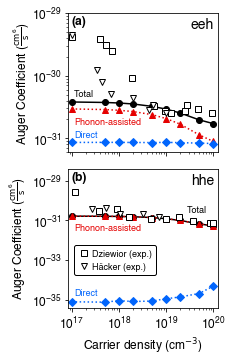

In [51]:
plt.close()
fig,ax = plt.subplots(figsize=(3.375,5.2),nrows=2,ncols=1,sharey=False,sharex=True)

ax[0].loglog(dens_df['dens'],dens_df['d_eeh']+dens_df['i_eeh'],marker='o',ls='-',color='xkcd:black',label='This Work Total')
ax[0].loglog(dens_df['dens'],dens_df['i_eeh'],marker='^',ls=':',color='xkcd:red',label='This Work Indirect')
ax[0].loglog(dens_df['dens'],dens_df['d_eeh'],marker='D',ls=':',color='xkcd:bright blue',label='This Work Direct')
ax[0].loglog(dziewior_eeh['n'],dziewior_eeh['ac'],marker='s',ls='',mec='xkcd:black',mfc='xkcd:white',label='Dziewior and Schmid')
ax[0].loglog(hacker_eeh['n'],hacker_eeh['ac'],marker='v',ls='',mec='xkcd:black',mfc='xkcd:white',label='Häcker and Hangleiter')

#ax[0].set_xlabel(r'Carrier density (cm$^{-3}$)')
ax[0].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)',labelpad=0)
ax[0].annotate('(a)',xy=(0.02,.92),xycoords='axes fraction',weight='bold',size='12')
ax[0].annotate('eeh',xy=(.82,.89),xycoords='axes fraction',size='14')
ax[0].annotate('Total',xy=(.04,.40),xycoords='axes fraction',size='9')
ax[0].annotate('Phonon-assisted',color='xkcd:red',xy=(.04,.2),xycoords='axes fraction',size='9')
ax[0].annotate('Direct',color='xkcd:bright blue',xy=(.04,.11),xycoords='axes fraction',size='9')


ax[1].loglog(dens_df['dens'],dens_df['d_hhe']+dens_df['i_hhe'],marker='o',ls='-',color='xkcd:black',label='Total (theory)')
ax[1].loglog(dens_df['dens'],dens_df['i_hhe'],marker='^',ls=':',color='xkcd:red',label='Indirect (theory)')
ax[1].loglog(dens_df['dens'],dens_df['d_hhe'],marker='D',ls=':',color='xkcd:bright blue',label='Direct (theory)')
ax[1].loglog(dziewior_hhe['n'],dziewior_hhe['ac'],marker='s',ls='',mec='xkcd:black',mfc='xkcd:white',label='Dziewior (exp.)')
ax[1].loglog(hacker_hhe['n'],hacker_hhe['ac'],marker='v',ls='',mec='xkcd:black',mfc='xkcd:white',label='Häcker (exp.)')
ax[1].set_xlabel(r'Carrier density (cm$^{-3}$)')
ax[1].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[1].annotate('(b)',xy=(0.02,0.92),xycoords='axes fraction',weight='bold',size='12')
ax[1].annotate('hhe',xy=(.82,.89),xycoords='axes fraction',size='14')
ax[1].annotate('Total',xy=(.79,.69),xycoords='axes fraction',size='9')
ax[1].annotate('Phonon-assisted',color='xkcd:red',xy=(.04,.56),xycoords='axes fraction',size='9')
ax[1].annotate('Direct',color='xkcd:bright blue',xy=(.04,.09),xycoords='axes fraction',size='9')

x_minor = LogLocator(subs=np.arange(1.0,10.0)*0.1,numticks=10)
ax[1].xaxis.set_minor_locator(x_minor)
ax[1].set_xticks([1e17,1e18,1e19,1e20])
ax[1].set_yticks([1e-35,1e-33,1e-31,1e-29])

legend_elements = [Line2D([0],[0],marker='s',mec='xkcd:black',mfc='xkcd:white',ls='',label=f'Dziewior (exp.)'),
                   Line2D([0],[0],marker='v',mec='xkcd:black',mfc='xkcd:white',ls='',label=f'Häcker (exp.)')]
ax[1].legend(handles=legend_elements,handletextpad=0.3,prop={'size': 9},loc=6,bbox_to_anchor=(0.01, 0.34),
             framealpha=1,edgecolor='xkcd:black',borderpad=0.4,handlelength=1.3)

ax[0].set_xlim([8.4e16,1.25e20])
ax[0].set_ylim([6e-32,1e-29])
ax[1].set_xlim([8.4e16,1.25e20])
ax[1].set_ylim([4e-36,4e-29])


plt.tight_layout()
#plt.savefig('Figure2.png',format='png',dpi=600,bbox_inches='tight')
plt.show()

### auger vs temp (Figure 3)

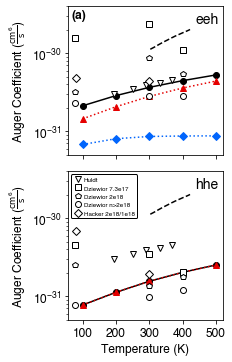

In [54]:
fig,ax = plt.subplots(figsize=(3.375,5.2),nrows=2,ncols=1,sharex=True)

ax[0].semilogy(temps_df['temp'],temps_df['d_eeh']+temps_df['i_eeh'],marker='o',ls='-',color='xkcd:black',label='This Work Total')
ax[0].semilogy(temps_df['temp'],temps_df['i_eeh'],marker='^',ls=':',color='xkcd:red',label='This Work Indirect')
ax[0].semilogy(temps_df['temp'],temps_df['d_eeh'],marker='D',ls=':',color='xkcd:bright blue',label='This Work Direct')
ax[0].semilogy(huldt_temp['temp'],huldt_temp['ac'],marker='v',ls='',mec='xkcd:black',mfc='xkcd:white',label='Huldt')
ax[0].semilogy(dziewior_eeh_temp.iloc[0:6:2]['temp'],dziewior_eeh_temp.iloc[0:6:2]['ac'],marker='s',ls='',mec='xkcd:black',mfc='xkcd:white',label='Dziewior 7.3e17')
ax[0].semilogy(dziewior_eeh_temp.iloc[1:6:2]['temp'],dziewior_eeh_temp.iloc[1:6:2]['ac'],marker='p',ls='',mec='xkcd:black',mfc='xkcd:white',label='Dziewior 2e18')
ax[0].semilogy([77,300,400],[2.3e-31,2.8e-31,2.8e-31],marker='o',ls='',mec='xkcd:black',mfc='xkcd:white',label='Dziewior 2e18')
ax[0].semilogy(jonsson_temp['temp'],jonsson_temp['ac'],ls='--',color='xkcd:black')
ax[0].semilogy(hacker_temp,hacker_eeh_ac,marker='D',ls='',mec='xkcd:black',mfc='xkcd:white',label='Hacker 2e18')

ax[0].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[0].annotate('(a)',xy=(0.02,.92),xycoords='axes fraction',weight='bold',size='12')
ax[0].annotate('eeh',xy=(.82,.89),xycoords='axes fraction',size='14')
#ax[0].annotate('Total',xy=(.04,.6),xycoords='axes fraction',size='9')
#ax[0].annotate('Phonon-assisted',color='xkcd:red',xy=(.4,.45),xycoords='axes fraction',size='9')
#ax[0].annotate('Direct',color='xkcd:bright blue',xy=(.04,.17),xycoords='axes fraction',size='9')

ax[1].semilogy(temps_df['temp'],temps_df['d_hhe']+temps_df['i_hhe'],marker='o',ls='-',color='xkcd:black',label='Total (theory)')
ax[1].semilogy(temps_df['temp'],temps_df['i_hhe'],marker='^',ls=':',color='xkcd:red',label='Indirect (theory)')
ax[1].semilogy(temps_df['temp'],temps_df['d_hhe'],marker='D',ls=':',color='xkcd:bright blue',label='Direct (theory)')
ax[1].semilogy(huldt_temp['temp'],huldt_temp['ac'],marker='v',ls='',mec='xkcd:black',mfc='xkcd:white',label='Huldt (exp.)')
ax[1].semilogy(dziewior_hhe_temp.iloc[0:6:2]['temp'],dziewior_hhe_temp.iloc[0:6:2]['ac'],marker='s',ls='',mec='xkcd:black',mfc='xkcd:white',label='Dziewior 7.3e17')
ax[1].semilogy(dziewior_hhe_temp.iloc[1:6:2]['temp'],dziewior_hhe_temp.iloc[1:6:2]['ac'],marker='p',ls='',mec='xkcd:black',mfc='xkcd:white',label='Dziewior 2e18')
ax[1].semilogy([77,300,400],[7.8e-32,9.9e-32,1.2e-31],marker='o',ls='',mec='xkcd:black',mfc='xkcd:white',label='Dziewior 2e18')
ax[1].semilogy(jonsson_temp['temp'],jonsson_temp['ac'],ls='--',color='xkcd:black')
ax[1].semilogy(hacker_temp,hacker_hhe_ac,marker='D',ls='',mec='xkcd:black',mfc='xkcd:white',label='Hacker 1e18')

ax[1].set_xlabel(r'Temperature (K)')
ax[1].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[1].annotate('(b)',xy=(0.02,0.92),xycoords='axes fraction',weight='bold',size='12')
ax[1].annotate('hhe',xy=(.82,.89),xycoords='axes fraction',size='14')
#ax[1].annotate('Total',xy=(.04,.26),xycoords='axes fraction',size='9')
#ax[1].annotate('Phonon-assisted',color='xkcd:red',xy=(.2,.15),xycoords='axes fraction',size='9')

ax[1].set_xticks(np.arange(100,600,100))

legend_elements = [Line2D([0],[0],marker='v',mec='xkcd:black',mfc='xkcd:white',ls='',label=f'Huldt'),
                   Line2D([0],[0],marker='s',mec='xkcd:black',mfc='xkcd:white',ls='',label=f'Dziewior 7.3e17'),
                   Line2D([0],[0],marker='p',mec='xkcd:black',mfc='xkcd:white',ls='',label=f'Dziewior 2e18'),
                   Line2D([0],[0],marker='o',mec='xkcd:black',mfc='xkcd:white',ls='',label=f'Dziewior n>2e18'),
                   Line2D([0],[0],marker='D',mec='xkcd:black',mfc='xkcd:white',ls='',label=f'Hacker 2e18/1e18')]
ax[1].legend(handles=legend_elements,handletextpad=0.3,prop={'size': 6.2},loc=2,#bbox_to_anchor=(0.01, 0.34),
             framealpha=1,edgecolor='xkcd:black',borderpad=0.4,handlelength=1.3)

ax[0].set_ylim([5e-32,4e-30])
ax[1].set_ylim([5e-32,4e-30])

plt.tight_layout()
#plt.savefig('Figure3_DRAFT.png',format='png',dpi=600,bbox_inches='tight')
plt.show()

### rough draft for density

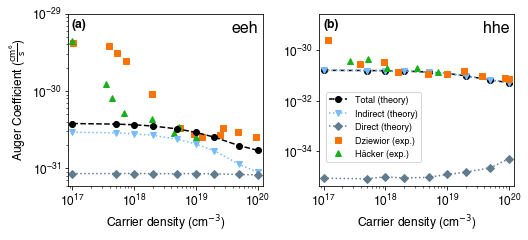

In [55]:
fig,ax = plt.subplots(figsize=(7.5,3.5),nrows=1,ncols=2,sharey=False)

ax[0].loglog(dziewior_eeh['n'],dziewior_eeh['ac'],marker='s',ls='',color='xkcd:orange',label='Dziewior and Schmid')
ax[0].loglog(hacker_eeh['n'],hacker_eeh['ac'],marker='^',ls='',color='xkcd:green',label='Häcker and Hangleiter')
ax[0].loglog(dens_df['dens'],dens_df['d_eeh']+dens_df['i_eeh'],marker='o',ls='--',color='xkcd:black',label='This Work Total')
ax[0].loglog(dens_df['dens'],dens_df['i_eeh'],marker='v',ls=':',color='xkcd:sky blue',label='This Work Indirect')
ax[0].loglog(dens_df['dens'],dens_df['d_eeh'],marker='D',ls=':',color='xkcd:blue grey',label='This Work Direct')
#ax[0].set_title(r'$eeh$ Auger')
ax[0].set_xlabel(r'Carrier density (cm$^{-3}$)')
ax[0].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
#ax[0].annotate('(a)',xy=(0,1.04),xycoords='axes fraction',weight='bold',size='12')
ax[0].annotate('(a)',xy=(0.02,.92),xycoords='axes fraction',weight='bold',size='12')
ax[0].annotate('eeh',xy=(.84,.89),xycoords='axes fraction',size='16')
#ax[0].legend(prop={'size': 9})

ax[1].loglog(dens_df['dens'],dens_df['d_hhe']+dens_df['i_hhe'],marker='o',ls='--',color='xkcd:black',label='Total (theory)')
ax[1].loglog(dens_df['dens'],dens_df['i_hhe'],marker='v',ls=':',color='xkcd:sky blue',label='Indirect (theory)')
ax[1].loglog(dens_df['dens'],dens_df['d_hhe'],marker='D',ls=':',color='xkcd:blue grey',label='Direct (theory)')
ax[1].loglog(dziewior_hhe['n'],dziewior_hhe['ac'],marker='s',ls='',color='xkcd:orange',label='Dziewior (exp.)')
ax[1].loglog(hacker_hhe['n'],hacker_hhe['ac'],marker='^',ls='',color='xkcd:green',label='Häcker (exp.)')
#ax[1].set_title(r'$hhe$ Auger')
ax[1].set_xlabel(r'Carrier density (cm$^{-3}$)')
#ax[1].annotate('(b)',xy=(0,1.04),xycoords='axes fraction',weight='bold',size='12')
ax[1].annotate('(b)',xy=(0.02,0.92),xycoords='axes fraction',weight='bold',size='12')
ax[1].annotate('hhe',xy=(.84,.89),xycoords='axes fraction',size='16')
#ax[1].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[1].legend(prop={'size': 9},loc=6,bbox_to_anchor=(0.01, 0.34))

ax[0].set_xlim([8.5e16,1.2e20])
ax[0].set_ylim([6e-32,1e-29])
ax[1].set_xlim([8.5e16,1.2e20])
ax[1].set_ylim([4e-36,3e-29])

plt.tight_layout()
#plt.savefig('auger_vs_carrier_dens.png',format='png',dpi=600,bbox_inches='tight')
plt.show()

### rough draft for temp

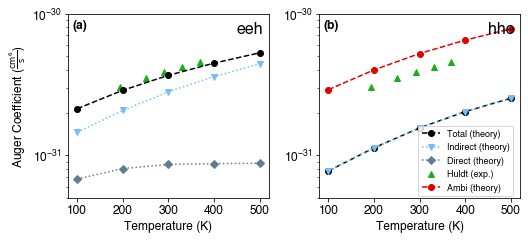

In [56]:
fig,ax = plt.subplots(figsize=(7.5,3.5),nrows=1,ncols=2,sharey=False)

#ax[0].semilogy(dziewior_eeh['n'],dziewior_eeh['ac'],marker='s',ls='',color='xkcd:orange',label='Dziewior and Schmid')
ax[0].semilogy(huldt_temp['temp'],huldt_temp['ac'],marker='^',ls='',color='xkcd:green',label='Huldt')
ax[0].semilogy(temps_df['temp'],temps_df['d_eeh']+temps_df['i_eeh'],marker='o',ls='--',color='xkcd:black',label='This Work Total')
ax[0].semilogy(temps_df['temp'],temps_df['i_eeh'],marker='v',ls=':',color='xkcd:sky blue',label='This Work Indirect')
ax[0].semilogy(temps_df['temp'],temps_df['d_eeh'],marker='D',ls=':',color='xkcd:blue grey',label='This Work Direct')
ax[0].set_xlabel(r'Temperature (K)')
ax[0].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[0].annotate('(a)',xy=(0.02,.92),xycoords='axes fraction',weight='bold',size='12')
ax[0].annotate('eeh',xy=(.84,.89),xycoords='axes fraction',size='16')

ax[1].semilogy(temps_df['temp'],temps_df['d_hhe']+temps_df['i_hhe'],marker='o',ls='--',color='xkcd:black',label='Total (theory)')
ax[1].semilogy(temps_df['temp'],temps_df['i_hhe'],marker='v',ls=':',color='xkcd:sky blue',label='Indirect (theory)')
ax[1].semilogy(temps_df['temp'],temps_df['d_hhe'],marker='D',ls=':',color='xkcd:blue grey',label='Direct (theory)')
ax[1].semilogy(huldt_temp['temp'],huldt_temp['ac'],marker='^',ls='',color='xkcd:green',label='Huldt (exp.)')
ax[1].semilogy(temps_df['temp'],temps_df['d_eeh']+temps_df['i_eeh']+temps_df['d_hhe']+temps_df['i_hhe'],marker='o',ls='--',color='xkcd:red',label='Ambi (theory)')
#ax[1].semilogy(dziewior_hhe['n'],dziewior_hhe['ac'],marker='s',ls='',color='xkcd:orange',label='Dziewior (exp.)')
#ax[1].semilogy(hacker_hhe['n'],hacker_hhe['ac'],marker='^',ls='',color='xkcd:green',label='Häcker (exp.)')
ax[1].set_xlabel(r'Temperature (K)')
ax[1].annotate('(b)',xy=(0.02,0.92),xycoords='axes fraction',weight='bold',size='12')
ax[1].annotate('hhe',xy=(.84,.89),xycoords='axes fraction',size='16')

ax[0].set_ylim([5e-32,1e-30])
#ax[1].set_ylim([1e-43,1e-28])
#ax[1].legend(prop={'size': 9},loc=7,bbox_to_anchor=(0.98, 0.2))
ax[1].set_ylim([5e-32,1e-30])
ax[1].legend(prop={'size': 9},loc=7,bbox_to_anchor=(0.99, 0.2))


plt.tight_layout()
#plt.savefig('auger_vs_temps.png',format='png',dpi=600,bbox_inches='tight')
plt.show()

### simple auger vs gap

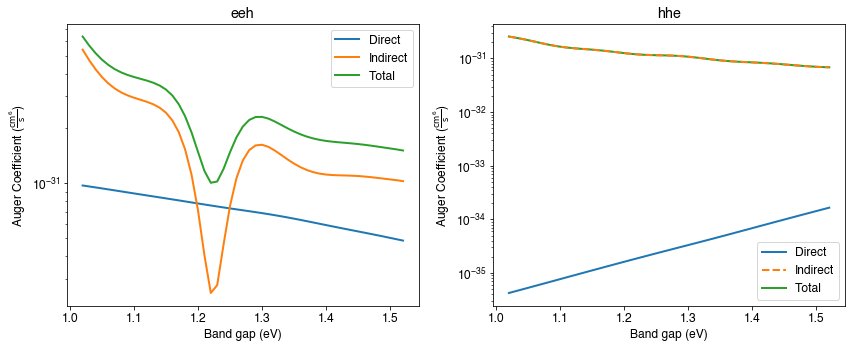

In [57]:
fig,ax = plt.subplots(figsize=(12,5),nrows=1,ncols=2,sharey=False)

ax[0].semilogy(simple_direct_eeh['gap'],simple_direct_eeh['ac'],lw=2,label='Direct')
ax[0].semilogy(simple_indirect_eeh['gap'],simple_indirect_eeh['fit_corrected'],lw=2,label='Indirect')
ax[0].semilogy(simple_direct_eeh['gap'],simple_direct_eeh['ac']+simple_indirect_eeh['fit_corrected'],lw=2,label='Total')

ax[0].set_title('eeh')
ax[0].set_xlabel('Band gap (eV)')
ax[0].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[0].legend()

direct_hhe = simple_direct_hhe.iloc[:51]
ax[1].semilogy(direct_hhe['gap'],direct_hhe['ac'],lw=2,label='Direct',zorder=3)
ax[1].semilogy(simple_indirect_hhe['gap'],simple_indirect_hhe['ac4'],lw=2,label='Indirect',ls='--',zorder=2)
ax[1].semilogy(direct_hhe['gap'],direct_hhe['ac']+simple_indirect_hhe['ac4'],lw=2,label='Total',zorder=1)

ax[1].set_title('hhe')
ax[1].set_xlabel('Band gap (eV)')
ax[1].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[1].legend()

#ax[0].set_xlim([1.01,1.2])
#ax[0].set_ylim([1.5e-31,6e-31])

plt.tight_layout()
plt.show()

### phonon absorption vs emission in indirect auger

given the size of the data file, not feasible to plot this vs gap, but can do a bar chart like in valley analysis

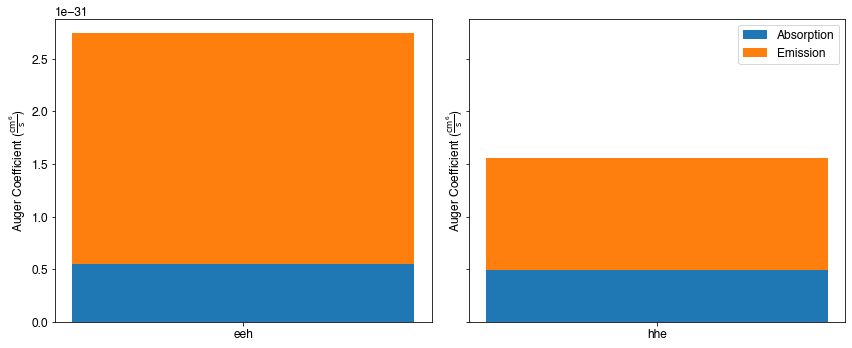

In [58]:
fig,ax = plt.subplots(figsize=(12,5),nrows=1,ncols=2,sharey=True)
'''
ax[0].semilogy(summed_eeh_abs['gap'],summed_eeh_abs['ab_corrected'],lw=2,label='Absorption')
ax[0].semilogy(summed_eeh_emit['gap'],summed_eeh_emit['ab_corrected'],lw=2,label='Emission')
ax[0].semilogy(summed_eeh_tot['gap'],summed_eeh_tot['ab_corrected'],lw=2,label='Total')

ax[0].set_title('Phonon-assisted eeh')
ax[0].set_xlabel('Band gap (eV)')
ax[0].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[0].legend()

ax[1].semilogy(summed_hhe_abs['gap'],summed_hhe_abs['ab_corrected'],lw=2,label='Absorption')
ax[1].semilogy(summed_hhe_emit['gap'],summed_hhe_emit['ab_corrected'],lw=2,label='Emission')
ax[1].semilogy(summed_hhe_tot['gap'],summed_hhe_tot['ab_corrected'],lw=2,label='Total')

ax[1].set_title('Phonon-assisted hhe')
ax[1].set_xlabel('Band gap (eV)')
ax[1].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[1].legend()

#ax[0].set_xlim(summed_eeh_tot['gap'].values[[0,-1]])
#ax[0].set_ylim([1.5e-31,6e-31])
'''
ax[0].bar(['eeh'],summed_eeh_abs['ab_corrected'],label='Absorption',log=False)
ax[0].bar(['eeh'],summed_eeh_emit['ab_corrected'],label='Emission',log=False,bottom=summed_eeh_abs['ab_corrected'])
ax[0].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')

ax[1].bar(['hhe'],summed_hhe_abs['ab_corrected'],label='Absorption',log=False)
ax[1].bar(['hhe'],summed_hhe_emit['ab_corrected'],label='Emission',log=False,bottom=summed_hhe_abs['ab_corrected'])
ax[1].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[1].legend()

plt.tight_layout()
plt.show()

### temperature dependence vs gap

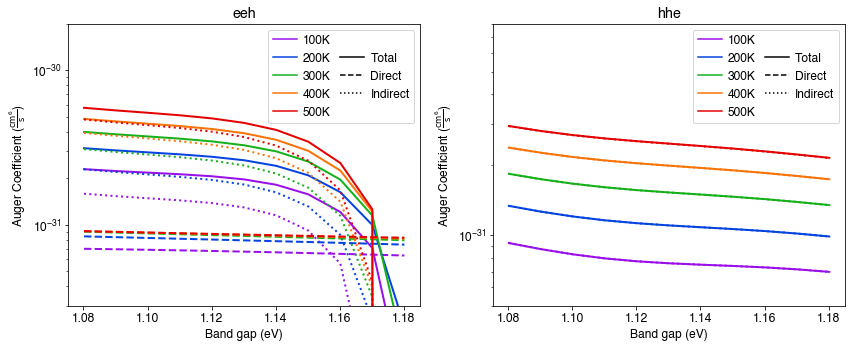

In [59]:
fig,ax = plt.subplots(figsize=(12,5),nrows=1,ncols=2,sharey=False)
colors = ['xkcd:violet','xkcd:blue','xkcd:green','xkcd:orange','xkcd:red']
legend_elements = []

for i,(temp,c) in enumerate(zip(range(100,505,100),colors)):
    ax[0].semilogy(direct_temps_eeh[i]['gap'],direct_temps_eeh[i]['ac'],lw=2,ls='--',c=c,label=f'Direct {temp}K')
    ax[0].semilogy(indirect_temps_eeh[i]['gap'],indirect_temps_eeh[i]['ab_corrected'],lw=2,ls=':',c=c,label=f'Indirect {temp}K')
    ax[0].semilogy(direct_temps_eeh[i]['gap'],direct_temps_eeh[i]['ac']+indirect_temps_eeh[i]['ab_corrected'],lw=2,ls='-',c=c,label=f'Total {temp}K')
    ax[1].semilogy(direct_temps_hhe[i]['gap'],direct_temps_hhe[i]['ac'],lw=2,ls='--',c=c,label=f'Direct {temp}K')
    ax[1].semilogy(indirect_temps_hhe[i]['gap'],indirect_temps_hhe[i]['ac4'],lw=2,ls=':',c=c,label=f'Indirect {temp}K')
    ax[1].semilogy(direct_temps_hhe[i]['gap'],direct_temps_hhe[i]['ac']+indirect_temps_hhe[i]['ac4'],lw=2,ls='-',c=c,label=f'Total {temp}K')
    legend_elements.append(Line2D([0],[0],c=c,ls='-',label=f'{temp}K'))
    '''
    ax[0].scatter(exp_gap,temps_df.iloc[i]['d_eeh'],c=c)
    ax[0].scatter(exp_gap,temps_df.iloc[i]['i_eeh'],c=c)
    ax[1].scatter(exp_gap,temps_df.iloc[i]['d_hhe'],c=c)
    ax[1].scatter(exp_gap,temps_df.iloc[i]['i_hhe'],c=c)
    '''
legend_elements.append(Line2D([0],[0],c='w',ls='-',label=f''))
legend_elements.append(Line2D([0],[0],c='k',ls='-',label=f'Total'))
legend_elements.append(Line2D([0],[0],c='k',ls='--',label=f'Direct'))
legend_elements.append(Line2D([0],[0],c='k',ls=':',label=f'Indirect'))

ax[0].set_title('eeh')
ax[0].set_xlabel('Band gap (eV)')
ax[0].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[0].legend(handles=legend_elements,ncol=2,columnspacing=0.8,handletextpad=0.5)

ax[1].set_title('hhe')
ax[1].set_xlabel('Band gap (eV)')
ax[1].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[1].legend(handles=legend_elements,ncol=2,columnspacing=0.8,handletextpad=0.5)

ax[0].set_ylim([3e-32,2e-30])
ax[1].set_ylim([5e-32,8e-31]) #indirect only
#ax[1].set_ylim([5e-44,8e-31]) #direct and indirect

plt.tight_layout()
plt.show()

### carrier dependence vs gap

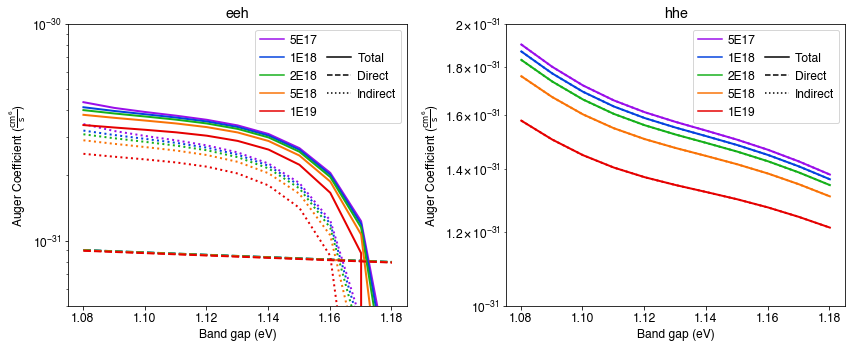

In [60]:
fig,ax = plt.subplots(figsize=(12,5),nrows=1,ncols=2,sharey=False)
colors = ['xkcd:violet','xkcd:blue','xkcd:green','xkcd:orange','xkcd:red']
legend_elements = []

for i,(den,c) in enumerate(zip(['5E17','1E18','2E18','5E18','1E19'],colors)):
    ax[0].semilogy(direct_dens_eeh[i]['gap'],direct_dens_eeh[i]['ac'],lw=2,ls='--',c=c,label=f'Direct {den}K')
    ax[0].semilogy(indirect_dens_eeh[i]['gap'],indirect_dens_eeh[i]['ab_corrected'],lw=2,ls=':',c=c,label=f'Indirect {den}K')
    ax[0].semilogy(direct_dens_eeh[i]['gap'],direct_dens_eeh[i]['ac']+indirect_dens_eeh[i]['ab_corrected'],lw=2,ls='-',c=c,label=f'Total {den}K')
    ax[1].semilogy(direct_dens_hhe[i]['gap'],direct_dens_hhe[i]['ac'],lw=2,ls='--',c=c,label=f'Direct {den}K')
    ax[1].semilogy(indirect_dens_hhe[i]['gap'],indirect_dens_hhe[i]['ac4'],lw=2,ls=':',c=c,label=f'Indirect {den}K')
    ax[1].semilogy(direct_dens_hhe[i]['gap'],direct_dens_hhe[i]['ac']+indirect_dens_hhe[i]['ac4'],lw=2,ls='-',c=c,label=f'Total {den}K')
    legend_elements.append(Line2D([0],[0],c=c,ls='-',label=f'{den}'))
    '''
    ax[0].scatter(exp_gap,dens_df.iloc[i]['d_eeh'],c=c)
    ax[0].scatter(exp_gap,dens_df.iloc[i]['i_eeh'],c=c)
    ax[1].scatter(exp_gap,dens_df.iloc[i]['d_hhe'],c=c)
    ax[1].scatter(exp_gap,dens_df.iloc[i]['i_hhe'],c=c)
    '''
legend_elements.append(Line2D([0],[0],c='w',ls='-',label=f''))
legend_elements.append(Line2D([0],[0],c='k',ls='-',label=f'Total'))
legend_elements.append(Line2D([0],[0],c='k',ls='--',label=f'Direct'))
legend_elements.append(Line2D([0],[0],c='k',ls=':',label=f'Indirect'))

ax[0].set_title('eeh')
ax[0].set_xlabel('Band gap (eV)')
ax[0].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[0].legend(handles=legend_elements,ncol=2,columnspacing=0.8,handletextpad=0.5)

ax[1].set_title('hhe')
ax[1].set_xlabel('Band gap (eV)')
ax[1].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[1].legend(handles=legend_elements,ncol=2,columnspacing=0.8,handletextpad=0.5)

ax[0].set_ylim([5e-32,1e-30])
ax[1].set_ylim([1e-31,2e-31]) #indirect only
#ax[1].set_ylim([5e-36,8e-31]) #direct and indirect
#ax[1].set_ylim([5e-36,2e-35]) #direct only

plt.tight_layout()
plt.show()

## Band structure

### GW bands and Auger cartoon

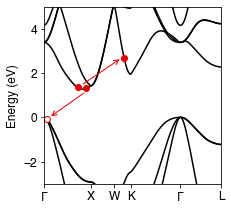

In [61]:
fig,ax = plt.subplots(figsize=(3.375,3.1))

val0 = 5.2084080
cbm_x = 0.9812286
cbm_y = 6.4787138-val0
vbm_x = 0
vbm_y = 0
bump = 0.07

for bi in range(26):
    start_i = bi*379
    end_i = (bi+1)*379
    ax.plot(gw_bands.iloc[start_i:end_i,:]['x'],gw_bands.iloc[start_i:end_i,:]['eig']-val0,color='xkcd:black')

ax.plot(cbm_x-.12,cbm_y+.09,marker='o',mec='xkcd:red',mfc='xkcd:red') #k1
ax.plot(cbm_x+.08,cbm_y+.05,marker='o',mec='xkcd:red',mfc='xkcd:red') #k2
ax.plot(vbm_x+.07,vbm_y-.07,marker='o',mec='xkcd:red',mfc='xkcd:white') #k3
ax.plot(cbm_x*2+.03,cbm_y*2+.13,marker='o',mec='xkcd:red',mfc='xkcd:red') #k4

#ax.annotate('',xy=(vbm_x+.14,vbm_y),xytext=(cbm_x-.18,cbm_y-.03),xycoords='data',arrowprops={'arrowstyle':'->','color':'xkcd:red'})
ax.annotate('',xy=(vbm_x+.14,vbm_y),xytext=(cbm_x+.05,cbm_y-.13),xycoords='data',arrowprops={'arrowstyle':'->','color':'xkcd:red'})
ax.annotate('',xy=(cbm_x*2-.03,cbm_y*2+.13),xytext=(cbm_x-.04,cbm_y+.19),xycoords='data',arrowprops={'arrowstyle':'->','color':'xkcd:red'})


ax.set_xlim([0,gw_label_info.iloc[-1,2]])
ax.set_ylim([-3,5])
ax.set_ylabel('Energy (eV)')
ax.set_xticks(np.append([0],gw_label_info['xtick'].values))
labels = [r'$\Gamma$','X','W','K',r'$\Gamma$','L']
ax.set_xticklabels(labels)

plt.tight_layout()
#plt.savefig('Figure1.png',format='png',dpi=600,bbox_inches='tight')
plt.show()

### GW and LDA comparison (referenced to GW VBM)

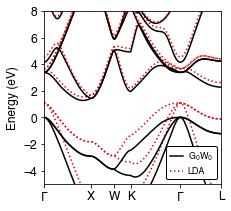

In [62]:
fig,ax = plt.subplots(figsize=(3.375,3.1))

val0 = 5.2084080
cbm_x = 0.9812286
cbm_y = 6.4787138-val0
vbm_x = 0
vbm_y = 0
bump = 0.07

for bi in range(26):
    start_i = bi*379
    end_i = (bi+1)*379
    ax.plot(gw_bands.iloc[start_i:end_i,:]['x'],gw_bands.iloc[start_i:end_i,:]['eig']-val0,color='xkcd:black',label='GW')
    ax.plot(lda_bands.iloc[start_i:end_i,:]['x'],lda_bands.iloc[start_i:end_i,:]['eig']-val0,color='xkcd:red',ls=':',label='LDA')

ax.set_xlim([0,gw_label_info.iloc[-1,2]])
ax.set_ylim([-5,8])
ax.set_ylabel('Energy (eV)')
ax.set_xticks(np.append([0],gw_label_info['xtick'].values))
labels = [r'$\Gamma$','X','W','K',r'$\Gamma$','L']
ax.set_xticklabels(labels)

legend_elements = [Line2D([0],[0],color='xkcd:black',ls='-',label=r'G$_0$W$_0$'),
                   Line2D([0],[0],color='xkcd:red',ls=':',label=f'LDA')]
ax.legend(handles=legend_elements,handletextpad=0.5,prop={'size': 9},loc=0,#bbox_to_anchor=(0.01, 0.34),
             framealpha=1,edgecolor='xkcd:black',borderpad=0.4,handlelength=1.5)

plt.tight_layout()
plt.show()

## Valley Analysis

### Bar chart comparison

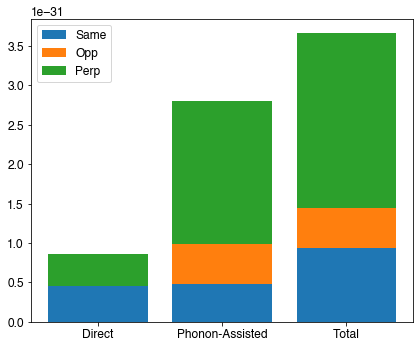

In [63]:
labels = ['Direct', 'Phonon-Assisted', 'Total']

direct_same = same_eeh_direct_summed.iloc[10]['ac']
direct_opp = opp_eeh_direct_summed.iloc[10]['ac']
direct_perp = perp_eeh_direct_summed.iloc[10]['ac']
indirect_same = same_eeh_indirect_summed.iloc[10]['fit_corrected']
indirect_opp = opp_eeh_indirect_summed.iloc[10]['fit_corrected']
indirect_perp = perp_eeh_indirect_summed.iloc[10]['fit_corrected']

same_data = np.array([direct_same,indirect_same,direct_same+indirect_same])
opp_data = np.array([direct_opp,indirect_opp,direct_opp+indirect_opp])
perp_data = np.array([direct_perp,indirect_perp,direct_perp+indirect_perp])

fig,ax = plt.subplots(figsize=(6,5),nrows=1,ncols=1,sharey=False)

ax.bar(labels,same_data,label='Same',log=False)
ax.bar(labels,opp_data,label='Opp',log=False,bottom=same_data)
ax.bar(labels,perp_data,label='Perp',log=False,bottom=same_data+opp_data)
#ax.set_ylim([1e-35,5e-31])
ax.legend()

plt.tight_layout()
plt.show()

### Pie chart comparison

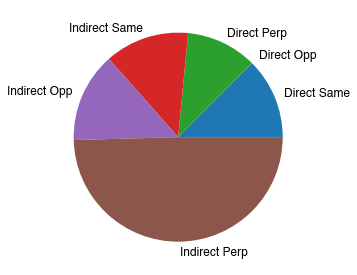

In [64]:
pie_labels = ['Direct Same', 'Direct Opp', 'Direct Perp', 'Indirect Same', 'Indirect Opp', 'Indirect Perp']
total_val = direct_same+indirect_same+direct_opp+indirect_opp+direct_perp+indirect_perp
#pie_data = [x/total_val for x in [direct_same,direct_opp,direct_perp,indirect_same,indirect_opp,indirect_perp]]
pie_data = [direct_same,direct_opp,direct_perp,indirect_same,indirect_opp,indirect_perp]

fig,ax = plt.subplots(figsize=(5,5),nrows=1,ncols=1,sharey=False)

ax.pie(x=pie_data,labels=pie_labels,normalize=True)

#ax.legend()

plt.tight_layout()
plt.show()

### eeh auger vs gap, decomposed direct indirect and valley groupings

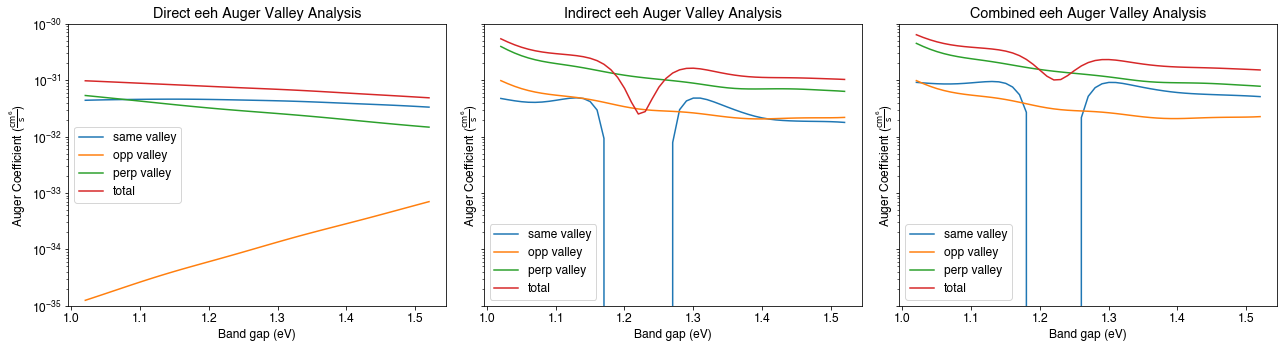

In [65]:
fig,ax = plt.subplots(figsize=(18,5),nrows=1,ncols=3,sharey=True)

ax[0].semilogy(same_eeh_direct_summed['gap'],same_eeh_direct_summed['ac'],label='same valley',ls='-')
ax[0].semilogy(opp_eeh_direct_summed['gap'],opp_eeh_direct_summed['ac'],label='opp valley',ls='-')
ax[0].semilogy(perp_eeh_direct_summed['gap'],perp_eeh_direct_summed['ac'],label='perp valley',ls='-')
ax[0].semilogy(simple_direct_eeh['gap'],simple_direct_eeh['ac'],label='total',ls='-')

ax[0].set_title('Direct eeh Auger Valley Analysis')
ax[0].set_xlabel('Band gap (eV)')
ax[0].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[0].legend()

ax[1].semilogy(same_eeh_indirect_summed['gap'],same_eeh_indirect_summed['fit_corrected'],label='same valley',ls='-')
ax[1].semilogy(opp_eeh_indirect_summed['gap'],opp_eeh_indirect_summed['fit_corrected'],label='opp valley',ls='-')
ax[1].semilogy(perp_eeh_indirect_summed['gap'],perp_eeh_indirect_summed['fit_corrected'],label='perp valley',ls='-')
ax[1].semilogy(simple_indirect_eeh['gap'],simple_indirect_eeh['fit_corrected'],label='total',ls='-')

ax[1].set_title('Indirect eeh Auger Valley Analysis')
ax[1].set_xlabel('Band gap (eV)')
ax[1].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[1].legend()

ax[2].semilogy(same_eeh_indirect_summed['gap'],same_eeh_direct_summed['ac']+same_eeh_indirect_summed['fit_corrected'],label='same valley',ls='-')
ax[2].semilogy(opp_eeh_indirect_summed['gap'],opp_eeh_direct_summed['ac']+opp_eeh_indirect_summed['fit_corrected'],label='opp valley',ls='-')
ax[2].semilogy(perp_eeh_indirect_summed['gap'],perp_eeh_direct_summed['ac']+perp_eeh_indirect_summed['fit_corrected'],label='perp valley',ls='-')
ax[2].semilogy(simple_indirect_eeh['gap'],simple_direct_eeh['ac']+simple_indirect_eeh['fit_corrected'],label='total',ls='-')

ax[2].set_title('Combined eeh Auger Valley Analysis')
ax[2].set_xlabel('Band gap (eV)')
ax[2].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[2].legend()

ax[0].set_ylim([1e-35,1e-30])
#ax[0].set_xlim([1.02,1.18])
#ax[1].set_xlim([1.02,1.18])
#ax[2].set_xlim([1.02,1.18])

plt.tight_layout()
plt.show()

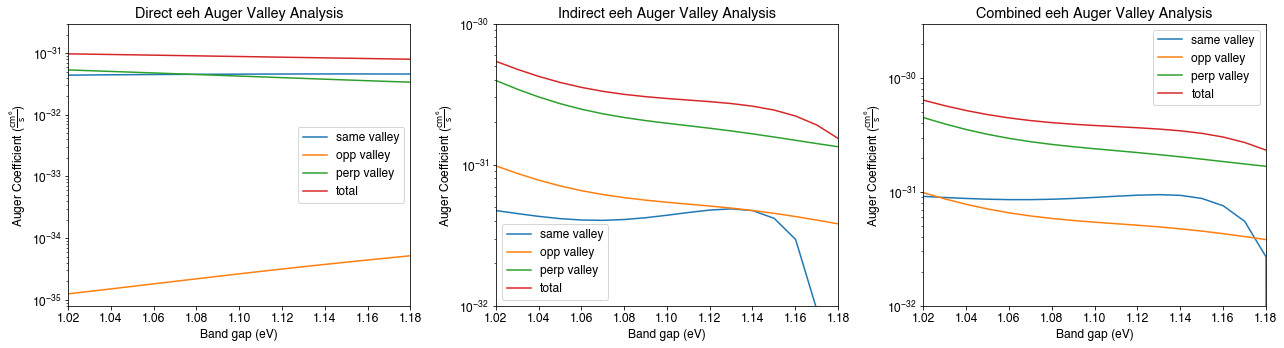

In [66]:
fig,ax = plt.subplots(figsize=(18,5),nrows=1,ncols=3,sharey=False)

ax[0].semilogy(same_eeh_direct_summed['gap'],same_eeh_direct_summed['ac'],label='same valley',ls='-')
ax[0].semilogy(opp_eeh_direct_summed['gap'],opp_eeh_direct_summed['ac'],label='opp valley',ls='-')
ax[0].semilogy(perp_eeh_direct_summed['gap'],perp_eeh_direct_summed['ac'],label='perp valley',ls='-')
ax[0].semilogy(simple_direct_eeh['gap'],simple_direct_eeh['ac'],label='total',ls='-')

ax[0].set_title('Direct eeh Auger Valley Analysis')
ax[0].set_xlabel('Band gap (eV)')
ax[0].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[0].legend()

ax[1].semilogy(same_eeh_indirect_summed['gap'],same_eeh_indirect_summed['fit_corrected'],label='same valley',ls='-')
ax[1].semilogy(opp_eeh_indirect_summed['gap'],opp_eeh_indirect_summed['fit_corrected'],label='opp valley',ls='-')
ax[1].semilogy(perp_eeh_indirect_summed['gap'],perp_eeh_indirect_summed['fit_corrected'],label='perp valley',ls='-')
ax[1].semilogy(simple_indirect_eeh['gap'],simple_indirect_eeh['fit_corrected'],label='total',ls='-')

ax[1].set_title('Indirect eeh Auger Valley Analysis')
ax[1].set_xlabel('Band gap (eV)')
ax[1].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[1].legend()

ax[2].semilogy(same_eeh_indirect_summed['gap'],same_eeh_direct_summed['ac']+same_eeh_indirect_summed['fit_corrected'],label='same valley',ls='-')
ax[2].semilogy(opp_eeh_indirect_summed['gap'],opp_eeh_direct_summed['ac']+opp_eeh_indirect_summed['fit_corrected'],label='opp valley',ls='-')
ax[2].semilogy(perp_eeh_indirect_summed['gap'],perp_eeh_direct_summed['ac']+perp_eeh_indirect_summed['fit_corrected'],label='perp valley',ls='-')
ax[2].semilogy(simple_indirect_eeh['gap'],simple_direct_eeh['ac']+simple_indirect_eeh['fit_corrected'],label='total',ls='-')

ax[2].set_title('Combined eeh Auger Valley Analysis')
ax[2].set_xlabel('Band gap (eV)')
ax[2].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[2].legend()

ax[0].set_xlim([1.02,1.18])
ax[0].set_ylim([8e-36,3e-31])
ax[1].set_xlim([1.02,1.18])
ax[1].set_ylim([1e-32,1e-30])
ax[2].set_xlim([1.02,1.18])
ax[2].set_ylim([1e-32,3e-30])

plt.tight_layout()
plt.show()

## Phonon Analysis

### "DOS" vs phonon freq

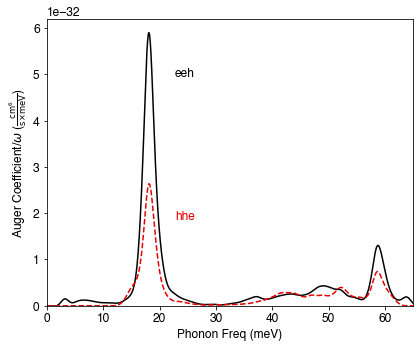

In [106]:
fig,ax = plt.subplots(figsize=(6,5))
ax.plot(freq_xs,eeh_freq_dos,color='xkcd:black')
ax.plot(freq_xs,hhe_freq_dos,color='xkcd:red',ls='--')
ax.set_ylim([0,6.2e-32])
ax.set_xlim([0,65])
ax.set_xlabel('Phonon Freq (meV)')
ax.set_ylabel(r'Auger Coefficient/$\omega$ ($\mathrm{\frac{cm^6}{s{\times}meV}}$)')
ax.annotate('eeh',xy=(.35,.8),xycoords='axes fraction',size='12',color='xkcd:black')
ax.annotate('hhe',xy=(.35,.3),xycoords='axes fraction',size='12',color='xkcd:red')
plt.tight_layout()
plt.show()

### "DOS" vs |q|

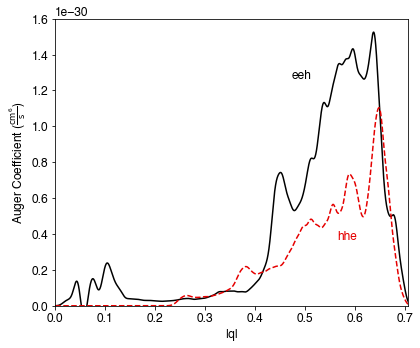

In [107]:
fig,ax = plt.subplots(figsize=(6,5))
ax.plot(iq_xs,eeh_magq_dos,color='xkcd:black')
ax.plot(iq_xs,hhe_magq_dos,color='xkcd:red',ls='--')
ax.set_xlim([0,np.sqrt(.5)])
ax.set_ylim([0,1.6e-30])
ax.set_xlabel('|q|')
ax.set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax.annotate('eeh',xy=(.67,.79),xycoords='axes fraction',size='12',color='xkcd:black')
ax.annotate('hhe',xy=(.8,.23),xycoords='axes fraction',size='12',color='xkcd:red')
plt.tight_layout()
plt.show()

## BZ visualizations

### cell definitions

In [128]:
def get_brillouin_zone_3d(cell):
    #this code taken from: http://staff.ustc.edu.cn/~zqj/posts/howto-plot-brillouin-zone/

    cell = np.asarray(cell, dtype=float)
    assert cell.shape == (3, 3)
    px, py, pz = np.tensordot(cell, np.mgrid[-1:2, -1:2, -1:2], axes=[0, 0])
    points = np.c_[px.ravel(), py.ravel(), pz.ravel()]

    from scipy.spatial import Voronoi
    vor = Voronoi(points)

    bz_facets = []
    bz_ridges = []
    bz_vertices = []
    for pid, rid in zip(vor.ridge_points, vor.ridge_vertices):
        if(pid[0] == 13 or pid[1] == 13):
            bz_ridges.append(vor.vertices[np.r_[rid, [rid[0]]]])
            bz_facets.append(vor.vertices[rid])
            bz_vertices += rid
    bz_vertices = list(set(bz_vertices))

    return vor.vertices[bz_vertices], bz_ridges, bz_facets

In [144]:
cell = np.array([[-0.5, 0.0, 0.5],
                 [0.0,  0.5, 0.5],
                 [-0.5, 0.5, 0.0]])

# basis vectors of the reciprocal lattice
icell = np.linalg.inv(cell).T                

v, e, f = get_brillouin_zone_3d(1.0*icell)
e_expanded = [1.025*e_array for e_array in e]

### carrier pockets

In [133]:
mlab.close(fig)
fig = mlab.figure(
    bgcolor=(1, 1, 1),
    size=(600, 600)
)
elec_color = colors.to_rgb('xkcd:red')
hole_color = colors.to_rgb('xkcd:sky blue')
nodes = mlab.points3d(cart_elec_pockets[:,0],cart_elec_pockets[:,1],cart_elec_pockets[:,2],
                      color=elec_color,scale_factor=0.08,opacity=1,figure=fig)
nodes = mlab.points3d(cart_hole_pockets[:,0],cart_hole_pockets[:,1],cart_hole_pockets[:,2],
                      color=hole_color,scale_factor=0.08,opacity=1,figure=fig)

#nodes.glyph.scale_mode = 'scale_by_vector'
#nodes.mlab_source.dataset.point_data.scalars = norm_color

for xx in e:
    mlab.plot3d(xx[:, 0], xx[:, 1], xx[:, 2],
                tube_radius=.008,
                color=(0, 0, 0), figure=fig)

mlab.view(azimuth=110,elevation=75,distance=5)
fig.scene.parallel_projection = True

#mlab.savefig('elec_indirect_BZ.png')
#full_elec_bz = mlab.screenshot(figure=fig, mode='rgba', antialiased=True)
#np.save('full_elec_bz_rgba',full_elec_bz)
#mlab.close(fig)
fig

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X\x00\x00\x02X\x08\x02\x00\x00\x001\x04\x0f\x8b\x…

In [212]:
fig = mlab.figure(
    bgcolor=(1, 1, 1),
    size=(600, 600)
)

max_ac = np.max(ac_eeh_mag)
cln = colors.LogNorm(vmin=1e-37, vmax=1.05*max_ac)
valid_points = ~(cln(no_core_eeh_ac).mask)
norm_color = cln(no_core_eeh_ac).data[valid_points]

nodes = mlab.points3d(no_core[valid_points,0],no_core[valid_points,1],no_core[valid_points,2],
                      colormap='viridis',vmin=0,vmax=1,
                      scale_factor=0.08,opacity=1, figure=fig)

#nodes.module_manager.scalar_lut_manager.lut.table = mb2_rgb
nodes.glyph.scale_mode = 'scale_by_vector'
nodes.mlab_source.dataset.point_data.scalars = norm_color

for xx in e_expanded:
    mlab.plot3d(xx[:, 0], xx[:, 1], xx[:, 2],
                tube_radius=.008,
                color=(0, 0, 0), figure=fig)

mlab.view(azimuth=-18,elevation=80,distance=5)
fig.scene.parallel_projection = True

fig
#mlab.savefig('eeh_indirect_BZ.png')
#full_eeh_bz = mlab.screenshot(figure=fig, mode='rgba', antialiased=True)
#np.save('./figures/full_eeh_bz_rgba',full_eeh_bz)
#mlab.close(fig)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X\x00\x00\x02X\x08\x02\x00\x00\x001\x04\x0f\x8b\x…

In [211]:
fig = mlab.figure(
    bgcolor=(1, 1, 1),
    size=(600, 600)
)

max_ac = np.max(ac_eeh_mag)
cln = colors.LogNorm(vmin=1e-37, vmax=1.05*max_ac)
valid_points = ~(cln(pos_x_eeh_ac).mask)
norm_color = cln(pos_x_eeh_ac).data[valid_points]

nodes = mlab.points3d(pos_x[valid_points,0],pos_x[valid_points,1],pos_x[valid_points,2],
                      colormap='viridis',vmin=0,vmax=1,
                      scale_factor=0.08,opacity=1, figure=fig)

#nodes.module_manager.scalar_lut_manager.lut.table = mb2_rgb
nodes.glyph.scale_mode = 'scale_by_vector'
nodes.mlab_source.dataset.point_data.scalars = norm_color

for xx in e_expanded:
    mlab.plot3d(xx[:, 0], xx[:, 1], xx[:, 2],
                tube_radius=.008,
                color=(0, 0, 0), figure=fig)

mlab.view(azimuth=120,elevation=75,distance=5)
fig.scene.parallel_projection = True

fig
#mlab.savefig('eeh_indirect_BZ_sliced.png')
#full_eeh_bz = mlab.screenshot(figure=fig, mode='rgba', antialiased=True)
#np.save('./figures/sliced_eeh_bz_rgba',full_eeh_bz)
#mlab.close(fig)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X\x00\x00\x02X\x08\x02\x00\x00\x001\x04\x0f\x8b\x…

In [213]:
fig = mlab.figure(
    bgcolor=(1, 1, 1),
    size=(600, 600)
)

max_ac = np.max(ac_hhe_mag)
cln = colors.LogNorm(vmin=1e-40, vmax=1.05*max_ac)
valid_points = ~(cln(no_core_hhe_ac).mask)
norm_color = cln(no_core_hhe_ac).data[valid_points]

nodes = mlab.points3d(no_core[valid_points,0],no_core[valid_points,1],no_core[valid_points,2],
                      colormap='viridis',vmin=0,vmax=1,
                      scale_factor=0.08,opacity=1, figure=fig)

#nodes.module_manager.scalar_lut_manager.lut.table = mb2_rgb
nodes.glyph.scale_mode = 'scale_by_vector'
nodes.mlab_source.dataset.point_data.scalars = norm_color

for xx in e_expanded:
    mlab.plot3d(xx[:, 0], xx[:, 1], xx[:, 2],
                tube_radius=.008,
                color=(0, 0, 0), figure=fig)

mlab.view(azimuth=-18,elevation=80,distance=5)
fig.scene.parallel_projection = True

fig
#mlab.savefig('hhe_indirect_BZ.png')
#full_hhe_bz = mlab.screenshot(figure=fig, mode='rgba', antialiased=True)
#np.save('./figures/full_hhe_bz_rgba',full_hhe_bz)
#mlab.close(fig)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X\x00\x00\x02X\x08\x02\x00\x00\x001\x04\x0f\x8b\x…

In [215]:
fig = mlab.figure(
    bgcolor=(1, 1, 1),
    size=(600, 600)
)

max_ac = np.max(ac_hhe_mag)
cln = colors.LogNorm(vmin=1e-40, vmax=1.05*max_ac)
valid_points = ~(cln(pos_x_hhe_ac).mask)
norm_color = cln(pos_x_hhe_ac).data[valid_points]

nodes = mlab.points3d(pos_x[valid_points,0],pos_x[valid_points,1],pos_x[valid_points,2],
                      colormap='viridis',vmin=0,vmax=1,
                      scale_factor=0.08,opacity=1, figure=fig)

#nodes.module_manager.scalar_lut_manager.lut.table = mb2_rgb
nodes.glyph.scale_mode = 'scale_by_vector'
nodes.mlab_source.dataset.point_data.scalars = norm_color

for xx in e_expanded:
    mlab.plot3d(xx[:, 0], xx[:, 1], xx[:, 2],
                tube_radius=.008,
                color=(0, 0, 0), figure=fig)

mlab.view(azimuth=120,elevation=75,distance=5)
fig.scene.parallel_projection = True

fig
#mlab.savefig('hhe_indirect_BZ_sliced.png')
#full_hhe_bz = mlab.screenshot(figure=fig, mode='rgba', antialiased=True)
#np.save('./figures/sliced_hhe_bz_rgba',full_hhe_bz)
#mlab.close(fig)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X\x00\x00\x02X\x08\x02\x00\x00\x001\x04\x0f\x8b\x…

## Combined Plots

### load BZ images

In [201]:
#BZ object images
full_eeh_bz = np.load('./figures/full_eeh_bz_rgba.npy')
full_hhe_bz = np.load('./figures/full_hhe_bz_rgba.npy')
slice_eeh_bz = np.load('./figures/sliced_eeh_bz_rgba.npy')
slice_hhe_bz = np.load('./figures/sliced_hhe_bz_rgba.npy')

### combined analysis plot (figure 4)

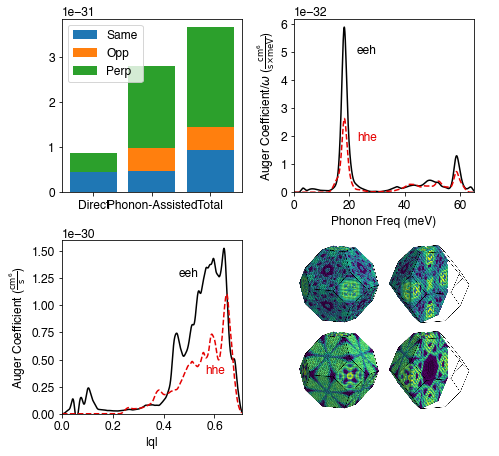

In [206]:
fig,ax = plt.subplots(figsize=(3.375*2,6.5),nrows=2,ncols=2)

labels = ['Direct', 'Phonon-Assisted', 'Total']
ax[0][0].bar(labels,same_data,label='Same',log=False)
ax[0][0].bar(labels,opp_data,label='Opp',log=False,bottom=same_data)
ax[0][0].bar(labels,perp_data,label='Perp',log=False,bottom=same_data+opp_data)
#ax.set_ylim([1e-35,5e-31])
ax[0][0].legend()

ax[0][1].plot(freq_xs,eeh_freq_dos,color='xkcd:black')
ax[0][1].plot(freq_xs,hhe_freq_dos,color='xkcd:red',ls='--')
ax[0][1].set_ylim([0,6.2e-32])
ax[0][1].set_xlim([0,65])
ax[0][1].set_xlabel('Phonon Freq (meV)')
ax[0][1].set_ylabel(r'Auger Coefficient/$\omega$ ($\mathrm{\frac{cm^6}{s{\times}meV}}$)')
ax[0][1].annotate('eeh',xy=(.35,.8),xycoords='axes fraction',size='12',color='xkcd:black')
ax[0][1].annotate('hhe',xy=(.35,.3),xycoords='axes fraction',size='12',color='xkcd:red')

ax[1][0].plot(iq_xs,eeh_magq_dos,color='xkcd:black')
ax[1][0].plot(iq_xs,hhe_magq_dos,color='xkcd:red',ls='--')
ax[1][0].set_xlim([0,np.sqrt(.5)])
ax[1][0].set_ylim([0,1.6e-30])
ax[1][0].set_xlabel('|q|')
ax[1][0].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[1][0].annotate('eeh',xy=(.65,.79),xycoords='axes fraction',size='12',color='xkcd:black')
ax[1][0].annotate('hhe',xy=(.8,.23),xycoords='axes fraction',size='12',color='xkcd:red')

im_eeh_full = OffsetImage(full_eeh_bz, zoom=.21)#.19
im_eeh_slice = OffsetImage(slice_eeh_bz, zoom=.21)
im_hhe_full = OffsetImage(full_hhe_bz, zoom=.21)
im_hhe_slice = OffsetImage(slice_hhe_bz, zoom=.21)

ab_eeh_full = AnnotationBbox(im_eeh_full,xy=(.25,.75),xycoords='axes fraction',pad=0,frameon=False) #(.63,.75)
ax[1][1].add_artist(ab_eeh_full)
ab_eeh_slice = AnnotationBbox(im_eeh_slice,xy=(.75,.75),xycoords='axes fraction',pad=0,frameon=False) #(.63,.75)
ax[1][1].add_artist(ab_eeh_slice)
ab_hhe_full = AnnotationBbox(im_hhe_full,xy=(.25,.25),xycoords='axes fraction',pad=0,frameon=False)
ax[1][1].add_artist(ab_hhe_full)
ab_hhe_slice = AnnotationBbox(im_hhe_slice,xy=(.75,.25),xycoords='axes fraction',pad=0,frameon=False)
ax[1][1].add_artist(ab_hhe_slice)
ax[1][1].set_axis_off()

plt.tight_layout()
plt.savefig('Figure4_DRAFT.png',format='png',dpi=600,bbox_inches='tight')
#plt.show()

### auger vs density with BZ insets

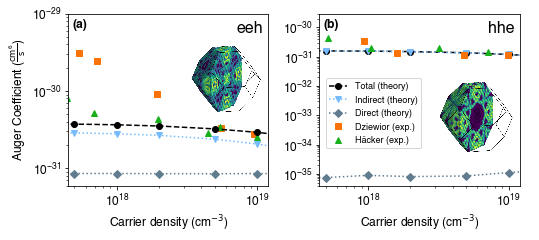

In [205]:
fig,ax = plt.subplots(figsize=(7.5,3.5),nrows=1,ncols=2,sharey=False)

im_eeh = OffsetImage(slice_eeh_bz, zoom=.18)
ab_eeh = AnnotationBbox(im_eeh,xy=(.79,.62),xycoords='axes fraction',pad=0,frameon=False) #(.63,.75)
im_hhe = OffsetImage(slice_hhe_bz, zoom=.19)
ab_hhe = AnnotationBbox(im_hhe,xy=(.78,.4),xycoords='axes fraction',pad=0,frameon=False)

ax[0].loglog(dziewior_eeh['n'],dziewior_eeh['ac'],marker='s',ls='',color='xkcd:orange',label='Dziewior and Schmid')
ax[0].loglog(hacker_eeh['n'],hacker_eeh['ac'],marker='^',ls='',color='xkcd:green',label='Häcker and Hangleiter')
ax[0].loglog(dens_df['dens'],dens_df['d_eeh']+dens_df['i_eeh'],marker='o',ls='--',color='xkcd:black',label='This Work Total')
ax[0].loglog(dens_df['dens'],dens_df['i_eeh'],marker='v',ls=':',color='xkcd:sky blue',label='This Work Indirect')
ax[0].loglog(dens_df['dens'],dens_df['d_eeh'],marker='D',ls=':',color='xkcd:blue grey',label='This Work Direct')
ax[0].add_artist(ab_eeh)
#ax[0].set_title(r'$eeh$ Auger')
ax[0].set_xlabel(r'Carrier density (cm$^{-3}$)')
ax[0].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
#ax[0].annotate('(a)',xy=(0,1.04),xycoords='axes fraction',weight='bold',size='12')
ax[0].annotate('(a)',xy=(0.02,.92),xycoords='axes fraction',weight='bold',size='12')
ax[0].annotate('eeh',xy=(.84,.89),xycoords='axes fraction',size='16')
#ax[0].legend(prop={'size': 9})

ax[1].loglog(dens_df['dens'],dens_df['d_hhe']+dens_df['i_hhe'],marker='o',ls='--',color='xkcd:black',label='Total (theory)')
ax[1].loglog(dens_df['dens'],dens_df['i_hhe'],marker='v',ls=':',color='xkcd:sky blue',label='Indirect (theory)')
ax[1].loglog(dens_df['dens'],dens_df['d_hhe'],marker='D',ls=':',color='xkcd:blue grey',label='Direct (theory)')
ax[1].loglog(dziewior_hhe['n'],dziewior_hhe['ac'],marker='s',ls='',color='xkcd:orange',label='Dziewior (exp.)')
ax[1].loglog(hacker_hhe['n'],hacker_hhe['ac'],marker='^',ls='',color='xkcd:green',label='Häcker (exp.)')
ax[1].add_artist(ab_hhe)
#ax[1].set_title(r'$hhe$ Auger')
ax[1].set_xlabel(r'Carrier density (cm$^{-3}$)')
#ax[1].annotate('(b)',xy=(0,1.04),xycoords='axes fraction',weight='bold',size='12')
ax[1].annotate('(b)',xy=(0.02,0.92),xycoords='axes fraction',weight='bold',size='12')
ax[1].annotate('hhe',xy=(.84,.89),xycoords='axes fraction',size='16')
#ax[1].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[1].legend(prop={'size': 9},loc=6,bbox_to_anchor=(0.01, 0.42))

#ax[0].set_xlim([3e17,2e19])
ax[0].set_xlim([4.5e17,1.2e19])
#ax[0].set_ylim([1e-31,1e-29])
ax[0].set_ylim([6e-32,1e-29])
#ax[1].set_xlim([3e17,2e19])
ax[1].set_xlim([4.5e17,1.2e19])
#ax[1].set_ylim([8e-32,1e-30])
ax[1].set_ylim([4e-36,3e-30])

plt.tight_layout()
#plt.savefig('auger_vs_carrier_dens_mrs_bz_slice.png',format='png',dpi=600,bbox_inches='tight')
plt.show()

## eeh indirect divergence

### im_eta vs gap with fit correction

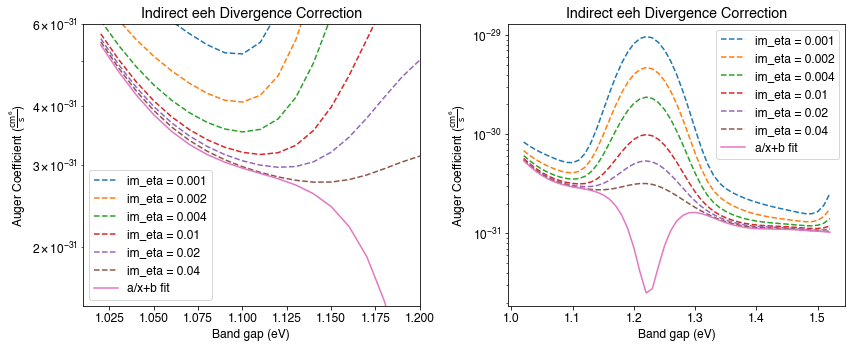

In [50]:
fig,ax = plt.subplots(figsize=(12,5),nrows=1,ncols=2,sharey=False)
x = simple_indirect_eeh['gap'].values
#0.001,0.002,0.004,0.010,0.020,0.040
#for eta, teta, label in zip(['ac1','ac2','ac4','ac5'],['ac2','ac3','ac5','ac6'],['2*.002-.001','2*.004-.002','2*.02-.01','2*.04-.02']):
    #ax[0].semilogy(x,simple_indirect_eeh[teta]*2-simple_indirect_eeh[eta],label=label,ls='--')
    #ax[1].semilogy(x,simple_indirect_eeh[teta]*2-simple_indirect_eeh[eta],label=label,ls='--')
for eta, label in zip(['ac1','ac2','ac3','ac4','ac5','ac6'],[0.001,0.002,0.004,0.010,0.020,0.040]):
    ax[0].semilogy(x,simple_indirect_eeh[eta],label=f'im_eta = {label}',ls='--')
    ax[1].semilogy(x,simple_indirect_eeh[eta],label=f'im_eta = {label}',ls='--')
    
ax[0].semilogy(x,simple_indirect_eeh['fit_corrected'],label='a/x+b fit')
ax[0].set_title('Indirect eeh Divergence Correction')
ax[0].set_xlabel('Band gap (eV)')
ax[0].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[0].legend()

ax[1].semilogy(x,simple_indirect_eeh['fit_corrected'],label='a/x+b fit')
ax[1].set_title('Indirect eeh Divergence Correction')
ax[1].set_xlabel('Band gap (eV)')
ax[1].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[1].legend()

ax[0].set_xlim([1.01,1.2])
ax[0].set_ylim([1.5e-31,6e-31])

plt.tight_layout()
plt.show()

### fit correction at 3 gap values

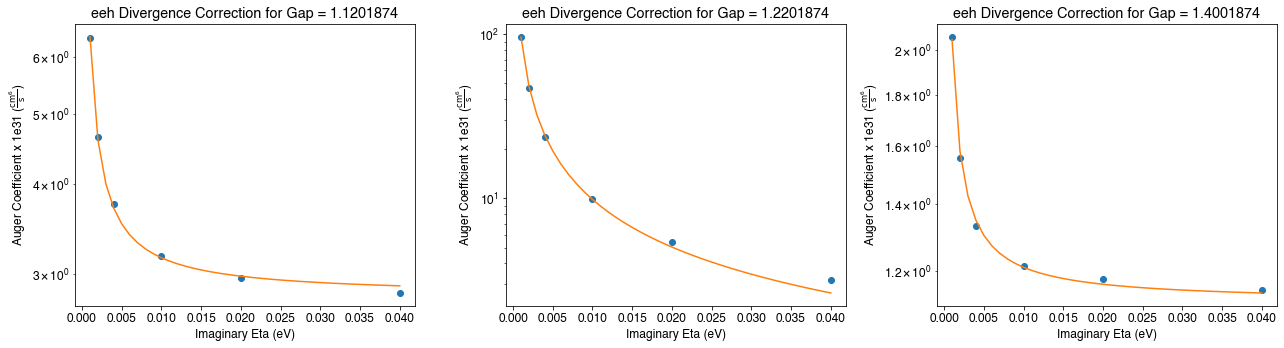

In [52]:
fig,ax = plt.subplots(figsize=(18,5),nrows=1,ncols=3,sharey=False)
x=np.array([.001,0.002,0.004,0.010,0.020,0.040])
scaler = 1e31

for i,gap in enumerate([1.1201874,1.2201874,1.4001874]):
    y=(simple_indirect_eeh[simple_indirect_eeh['gap']==gap].iloc[:,1:7].values*scaler).flatten()
    (a,b), _ = curve_fit(func, x, y)
    ax[i].semilogy(x,y,marker='o',ls='')
    smooth_x = np.arange(x[0],x[-1]+.001,.001)
    ax[i].semilogy(smooth_x,func(smooth_x,a,b))
    ax[i].set_title(f'eeh Divergence Correction for Gap = {gap}')
    ax[i].set_xlabel('Imaginary Eta (eV)')
    ax[i].set_ylabel(r'Auger Coefficient x 1e31 ($\mathrm{\frac{cm^6}{s}}$)')

plt.tight_layout()
plt.show()

### variable power fit correction at three gap values

0.0068749602595404285 0.9085071156422552 2.7157106143930965
0.06606232768166719 1.0529163550573661 1.3524270039991901
0.00036798610128737383 1.1323167813061772 1.1426346105951999


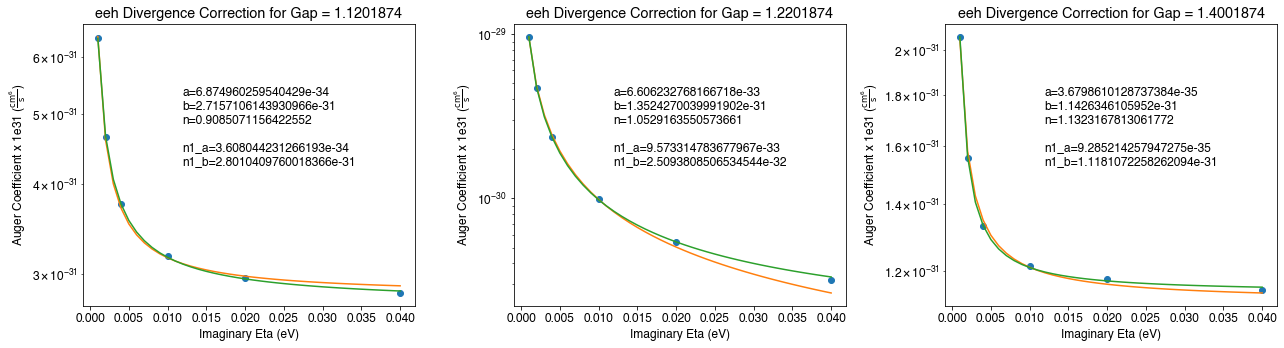

In [54]:
fig,ax = plt.subplots(figsize=(18,5),nrows=1,ncols=3,sharey=False)
x=np.array([.001,0.002,0.004,0.010,0.020,0.040])
scaler = 1e31

def test_func(x, a, n, b):
    #n=1
    return a/x**n + b

for i,gap in enumerate([1.1201874,1.2201874,1.4001874]):
    y=(simple_indirect_eeh[simple_indirect_eeh['gap']==gap].iloc[:,1:7].values*scaler).flatten()
    (a,n,b), _ = curve_fit(test_func, x, y)
    (n1_a,n1_b), _ = curve_fit(func,x,y)
    print(a,n,b)
    ax[i].semilogy(x,y/scaler,marker='o',ls='')
    smooth_x = np.arange(x[0],x[-1]+.001,.001)
    ax[i].semilogy(smooth_x,func(smooth_x,n1_a/scaler,n1_b/scaler))
    ax[i].semilogy(smooth_x,test_func(smooth_x,a/scaler,n,b/scaler))
    ax[i].annotate(f'a={a/scaler}\nb={b/scaler}\nn={n}\n\nn1_a={n1_a/scaler}\nn1_b={n1_b/scaler}',(.3,.5),xycoords='axes fraction')
    ax[i].set_title(f'eeh Divergence Correction for Gap = {gap}')
    ax[i].set_xlabel('Imaginary Eta (eV)')
    ax[i].set_ylabel(r'Auger Coefficient x 1e31 ($\mathrm{\frac{cm^6}{s}}$)')

plt.tight_layout()
plt.show()

## screening model comparison

### constants and basic models

In [72]:
bohr2cm = 5.29177249e-9
kelvin2au = 3.16682968067e-6
ev2ha = 1/27.2113961318

eps_infty = 11.7
n_density = np.array([1e17, 5e17, 1e18, 2e18, 5e18, 1e19, 2e19, 5e19, 1e20]) * (bohr2cm)**3
kT = 300*kelvin2au
efermi_elec = np.array([-.140347033739096,-.098622329533108,-.080556571483613,-.062344819307329,
                        -.037783533334728,-.018420666456213,.002348348498350,.034296885132797,
                        .065125524997723])*ev2ha
lambda2_tf = 4 * np.pi * ( 1.5 * n_density/(eps_infty*efermi_elec) ) #TF
lambda2_dh = 4 * np.pi * n_density / (eps_infty*kT) #DH
lambda2_smooth = lambda2_tf * ( 1 - np.exp(-efermi_elec/(1.5*kT)))

### basic min function

In [86]:
minfunc = np.zeros(lambda2_dh.shape)
for i,e in enumerate(efermi_elec):
    if e <= 0:
        minfunc[i] = lambda2_dh[i]
    else:
        minfunc[i] = np.minimum(lambda2_dh[i],lambda2_tf[i])

### variety of smoothing functions

In [74]:
efermi_elec = np.arange(-0.155,0.16,.01)*ev2ha
n_density = np.logspace(16,21,num=32)*(bohr2cm)**3
lambda2_tf = 4 * np.pi * ( 1.5 * n_density/(eps_infty*efermi_elec) ) #TF
lambda2_dh = 4 * np.pi * n_density / (eps_infty*kT) #DH
lambda2_smooth = lambda2_tf * ( 1 - np.exp(-efermi_elec/(1.5*kT)))
lambda2_smooth2 = lambda2_dh * ( 1 - np.exp(-(1.5*kT)/efermi_elec))
smoother = (kT*1/(1+np.exp(2*efermi_elec/kT))+1/1.5*efermi_elec*(1-1/(1+np.exp(2*efermi_elec/kT))))
smoother2 = np.sqrt(((kT*1/(1+np.exp(2*efermi_elec/kT)))**2+(1/1.5*efermi_elec*(1-1/(1+np.exp(2*efermi_elec/kT))))**2))
smoother3 = (kT*1/(1+np.exp(10*(efermi_elec-2*kT)/kT))+1/1.5*efermi_elec*(1-1/(1+np.exp(10*(efermi_elec-2*kT)/kT))))

lambda2_3 = 4 * np.pi * n_density/(eps_infty*smoother2)
lambda2_4 = 4 * np.pi * n_density/(eps_infty*smoother3)
#lambda2_4 = lambda2_dh*(1.5*kT/efermi_elec)*(1-(np.tanh(-100*efermi_elec/kT)+1)/2)

#alpha = (1.5*kT/efermi_elec)**2
#beta = lambda2_tf**2
#l = (-alpha+np.sqrt(alpha**2-4*beta)/2)*4*np.pi*n_density/eps_infty

### parallel resistor models

In [76]:
one_over_tf2 = 1/lambda2_tf
one_over_tf2[:16] = 0
one_over_tf = np.sqrt(one_over_tf2)

one_over_dh2 = 1/lambda2_dh
one_over_dh = np.sqrt(one_over_dh2)

### plot comparisons

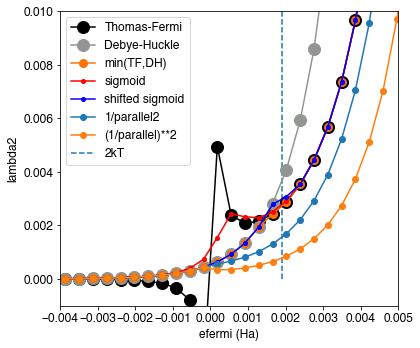

In [90]:
fig,ax = plt.subplots(figsize=(6,5),nrows=1,ncols=1,sharey=False)

ax.plot(efermi_elec, lambda2_tf, marker='o',label='Thomas-Fermi',markersize=12,c='k')
ax.plot(efermi_elec, lambda2_dh, marker='o',label='Debye-Huckle',markersize=12,c='xkcd:grey')
ax.plot(efermi_elec, minfunc, marker='o',label='min(TF,DH)',markersize=8,c='xkcd:orange')
ax.plot(efermi_elec, lambda2_3, marker='o',label='sigmoid',markersize=4,c='r')
ax.plot(efermi_elec, lambda2_4, marker='o',label='shifted sigmoid',markersize=4,c='b')
ax.plot(efermi_elec,1/(one_over_tf2+one_over_dh2),marker='o',label='1/parallel2')
ax.plot(efermi_elec,1/(one_over_tf+one_over_dh)**2,marker='o',label='(1/parallel)**2')

#ax.semilogy(efermi_elec, lambda2_smooth, marker='o',label='smooth')

#ax.semilogy(efermi_elec, lambda2_tf, marker='o',label='Thomas-Fermi',markersize=12,c='k')
#ax.semilogy(efermi_elec, lambda2_dh, marker='o',label='Debye-Huckle',markersize=12,c='xkcd:grey')
#ax.semilogy(efermi_elec, minfunc, marker='o',label='min(TF,DH)',markersize=8,c='xkcd:orange')
#ax.semilogy(efermi_elec, lambda2_3, marker='o',label='sigmoid',markersize=4,c='r')
#ax.semilogy(efermi_elec, lambda2_4, marker='o',label='shifted sigmoid',markersize=4,c='b')
ax.vlines(x=2*kT,ymin=2e-6,ymax=2e-1,label='2kT',ls='--')

#ax2 = ax.twiny()
#ax2.set_xlim(ax.get_xlim())
#ax2.set_xticks(efermi_elec)
#ax2.set_xticklabels([str(n) for n in [1e17, 5e17, 1e18, 2e18, 5e18, 1e19, 2e19, 5e19, 1e20]])

ax.legend()
ax.set_xlabel(r'efermi (Ha)')
#ax2.set_xlabel(r'n_density (cm^-3)')
ax.set_ylabel(r'lambda2')

#zoomed view
#ax.set_xlim([-.002,.0035])
#ax.set_ylim([0,.005])

ax.set_xlim([-.004,.005])
ax.set_ylim([-0.001,0.01])

plt.tight_layout()
plt.show()

## Coulomb Enchancement

empirical model used by Black and Macdonald, from Jonsson https://aip.scitation.org/doi/abs/10.1063/1.364277
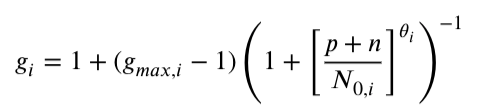
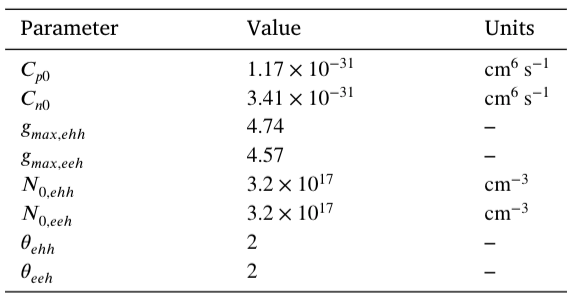

### data creation for functions

In [69]:
x = coulomb_geeh['dens'].values
y = coulomb_geeh['geeh'].values

arb_x = np.logspace(16,20,num=100)
arb_y = np.interp(arb_x, x, y)

den_x = dens_df['dens'].values
den_y = np.interp(den_x, x, y)

### lit models

In [70]:
black_y = 1+(4.57-1)/(1+(arb_x/3.2e17)**2)
richter_y = 1+13*(1-np.tanh((arb_x/3.3e17)**0.66))

den_black_y  = 1+(4.57-1)/(1+(den_x/3.2e17)**2)

### plot g and effect on eeh auger

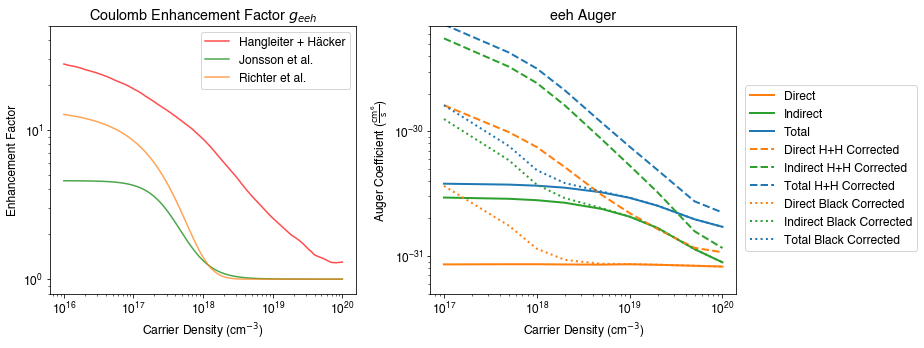

In [71]:
fig,ax = plt.subplots(figsize=(13,5),nrows=1,ncols=2,sharey=False)

#ax[0].loglog(coulomb_geeh['dens'],coulomb_geeh['geeh'],lw=2,label=r'Hangleiter + Häcker',marker='^')
#ax[0].loglog(richter_geeh['dens'],richter_geeh['geeh'])
ax[0].loglog(arb_x,arb_y,c='r',alpha=0.7,label='Hangleiter + Häcker')
ax[0].loglog(arb_x,black_y,c='g',alpha=0.7,label='Jonsson et al.')
ax[0].loglog(arb_x,richter_y,c=default_colors[1],alpha=0.7,label='Richter et al.')
ax[0].set_title(r'Coulomb Enhancement Factor $g_{eeh}$')
ax[0].set_xlabel(r'Carrier Density (cm$^{-3}$)')
ax[0].set_ylabel(r'Enhancement Factor')
ax[0].legend()

ax[1].loglog(den_x,dens_df['d_eeh'],lw=2,ls='-',c=default_colors[1],label='Direct')
ax[1].loglog(den_x,dens_df['i_eeh'],lw=2,ls='-',c=default_colors[2],label='Indirect')
ax[1].loglog(den_x,dens_df['d_eeh']+dens_df['i_eeh'],lw=2,ls='-',c=default_colors[0],label='Total')
ax[1].loglog(den_x,dens_df['d_eeh'].values*den_y,lw=2,ls='--',c=default_colors[1],label='Direct H+H Corrected')
ax[1].loglog(den_x,dens_df['i_eeh'].values*den_y,lw=2,ls='--',c=default_colors[2],label='Indirect H+H Corrected')
ax[1].loglog(den_x,(dens_df['d_eeh'].values+dens_df['i_eeh'].values)*den_y,lw=2,ls='--',c=default_colors[0],label='Total H+H Corrected')
ax[1].loglog(den_x,dens_df['d_eeh'].values*den_black_y,lw=2,ls=':',c=default_colors[1],label='Direct Black Corrected')
ax[1].loglog(den_x,dens_df['i_eeh'].values*den_black_y,lw=2,ls=':',c=default_colors[2],label='Indirect Black Corrected')
ax[1].loglog(den_x,(dens_df['d_eeh'].values+dens_df['i_eeh'].values)*den_black_y,lw=2,ls=':',c=default_colors[0],label='Total Black Corrected')

ax[1].set_title('eeh Auger')
ax[1].set_xlabel(r'Carrier Density (cm$^{-3}$)')
ax[1].set_ylabel(r'Auger Coefficient ($\mathrm{\frac{cm^6}{s}}$)')
ax[1].legend(bbox_to_anchor=(1.01, .8))

#ax[0].set_xlim(summed_eeh_tot['gap'].values[[0,-1]])
ax[0].set_ylim([8e-1,5e1])
ax[1].set_ylim([5e-32,7e-30])

plt.tight_layout()
plt.show()